# VarClump2D: Agglomeration test


In [1]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider, IntSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

# pycupid
from pycupid import *

# just for presentation
import warnings
warnings.filterwarnings("ignore")

## Loading `Orion KL`

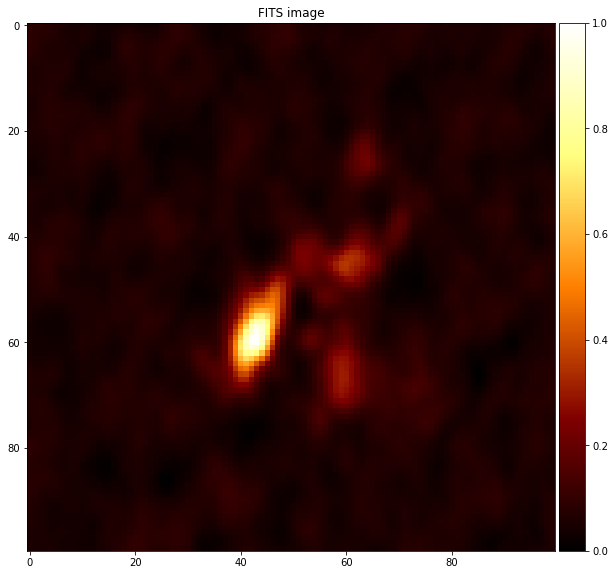

In [2]:
fits_path = '../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level*0.9 ,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

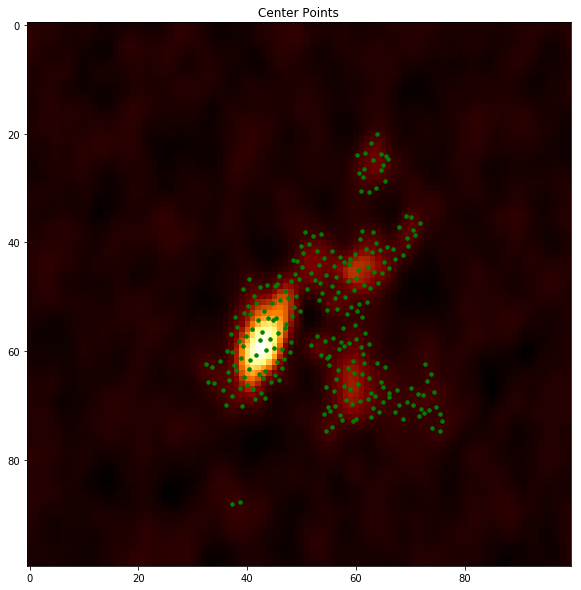

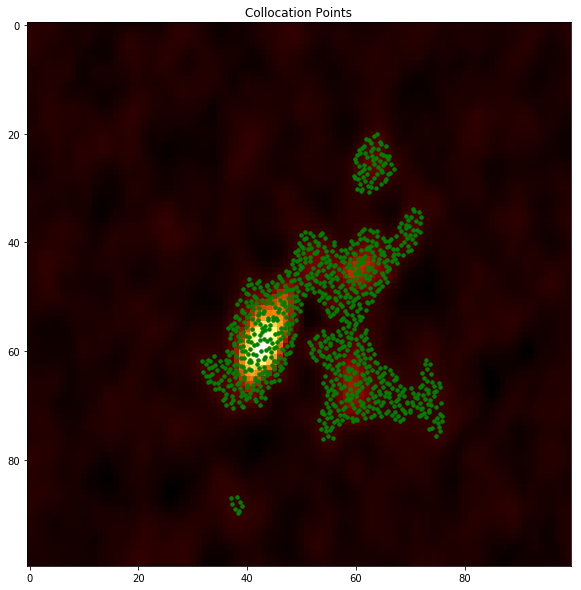

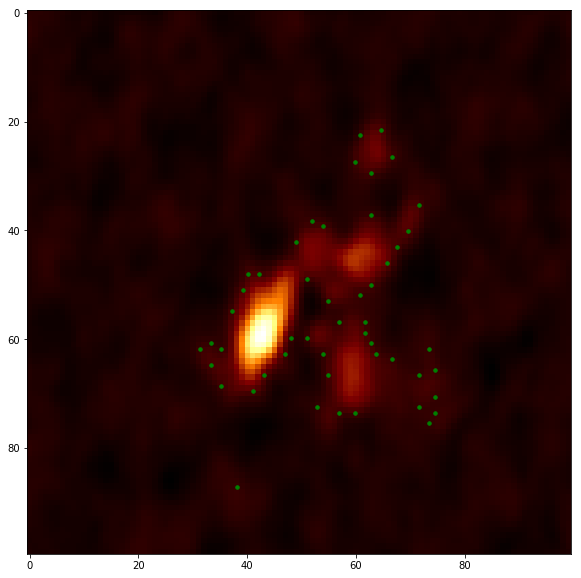

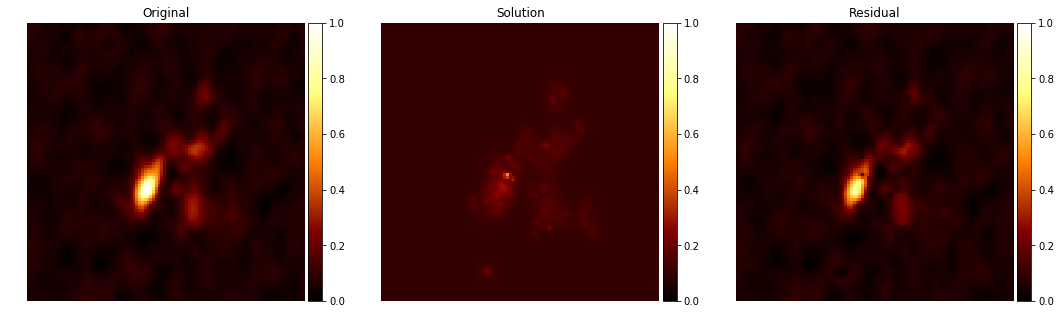

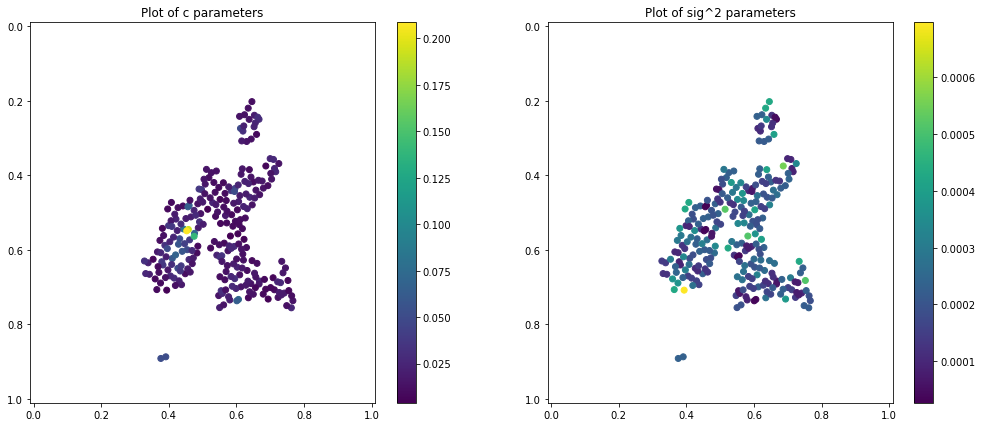

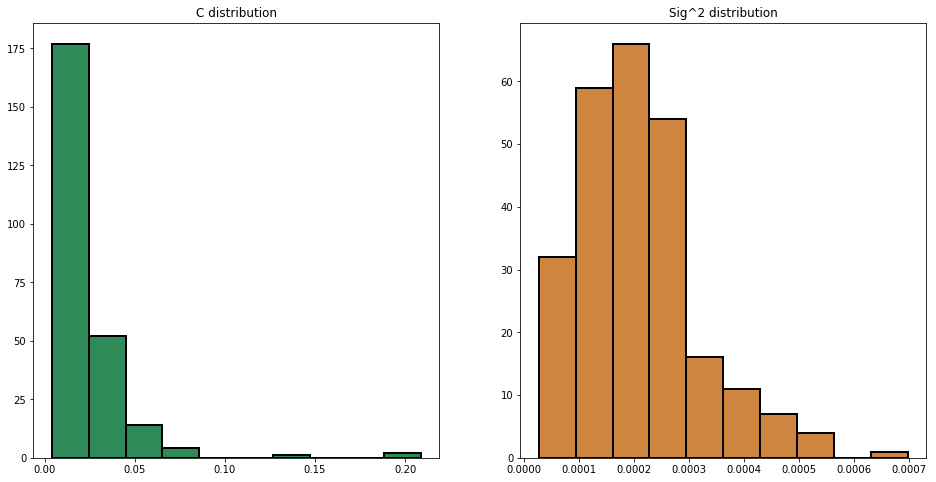

In [4]:
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
    
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100111

Residual stats:
Residual RMS: 0.004390678432191209
Residual Variance: 1.8984267486917232e-05
Flux Lost: 0.00833553924676117
Flux Addition: 0.0057988135219269234
psi1(u-f): 0.0008805157567228889
Exceeded Pixels: 429
Sharpness: 45.949381157199504
psi2(grad u): 44.189369745045056
Total elapsed time: 281.81452989578247 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.023606571278144698
Mean min distance between collocation and center points: 0.00888348534898836

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.0725397371580878
Max min distance in the (standarized) parameters space: 0.3859693314549751


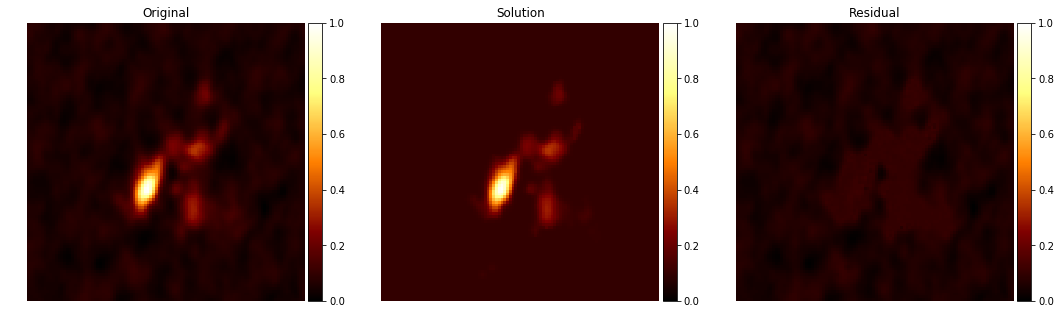

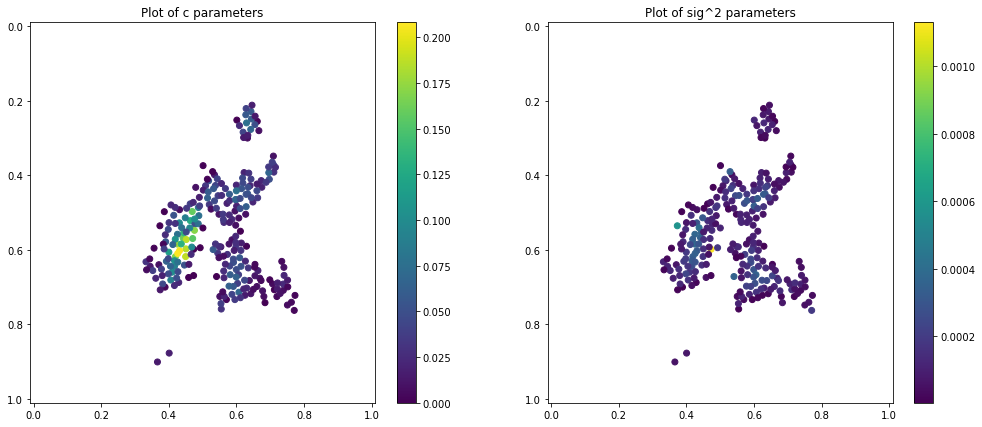

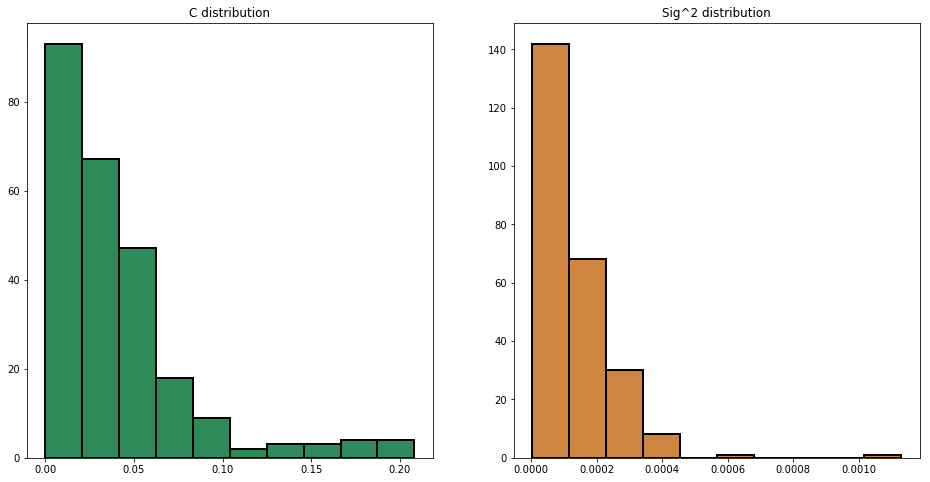

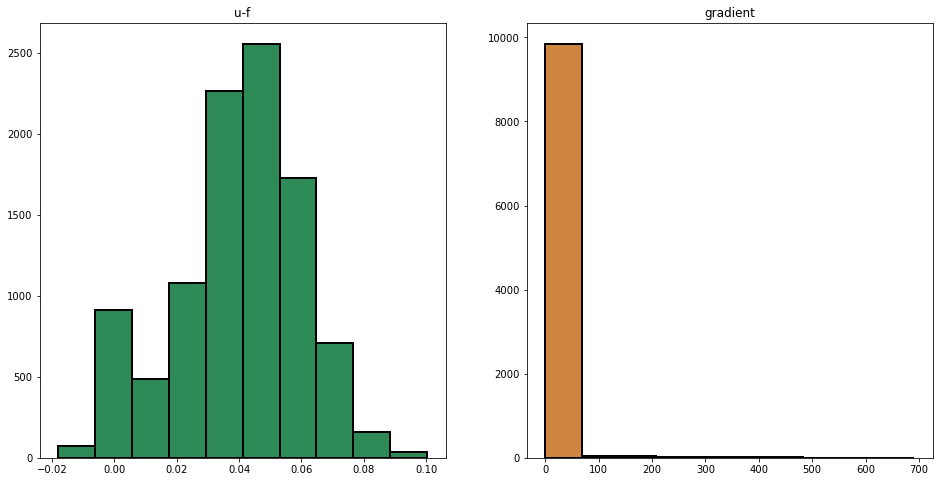

In [5]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [6]:
elm01.prune()
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

### Agglomeration with `KL-divergence` (upper bound)

In [7]:
components_dict01, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 106 and 231 with 1.1482965085926726e-07 KL dist and 5.006046626570673e-12 ISD dist
Merged components 1 and 106 with 1.6627893930097997e-07 KL dist and 1.3232312212674345e-11 ISD dist
Merged components 64 and 137 with 2.4930670130933214e-07 KL dist and 1.3572576894276007e-10 ISD dist
Merged components 11 and 166 with 3.889722973950932e-07 KL dist and 2.4409025137792595e-10 ISD dist
Merged components 5 and 47 with 4.98605903334742e-07 KL dist and 1.6277266254130285e-10 ISD dist
Merged components 0 and 29 with 5.48509918642259e-07 KL dist and 3.3665900788007205e-10 ISD dist
Merged components 117 and 156 with 5.584127916294517e-07 KL dist and 9.718514396983292e-11 ISD dist
Merged components 66 and 215 with 5.933031181681585e-07 KL dist and 6.470017998075346e-10 ISD dist
Merged components 0 and 135 with 6.282290911023114e-07 KL dist and 1.9542684119918607e-10 ISD dist
Merged components 30 and 102 with 6.660824345299681e-07 KL dist and 8.257527590383842e-11 ISD dist
Merged 

Merged components 101 and 103 with 7.839766175144302e-06 KL dist and 4.128659656666849e-09 ISD dist
Merged components 113 and 115 with 7.993812106808223e-06 KL dist and 4.535987583703018e-09 ISD dist
Merged components 26 and 38 with 8.001116198892624e-06 KL dist and 9.018171903015254e-09 ISD dist
Merged components 75 and 88 with 8.12975173881142e-06 KL dist and 3.18439597613425e-08 ISD dist
Merged components 8 and 37 with 8.588737569711436e-06 KL dist and 9.38330257106237e-09 ISD dist
Merged components 14 and 82 with 8.729513341837968e-06 KL dist and 1.4849714388416671e-08 ISD dist
Merged components 35 and 87 with 8.792195873784308e-06 KL dist and 6.919189074530146e-09 ISD dist
Merged components 55 and 82 with 8.902317691456601e-06 KL dist and 1.2763123357938087e-08 ISD dist
Merged components 30 and 119 with 8.985950023784937e-06 KL dist and 6.1303032034413294e-09 ISD dist
Merged components 60 and 84 with 9.556515712391873e-06 KL dist and 8.718450529664343e-09 ISD dist
Merged component

Merged components 2 and 18 with 5.317501988604315e-05 KL dist and 8.02537266885776e-08 ISD dist
Merged components 1 and 3 with 5.3683921180654876e-05 KL dist and 6.353957468682489e-07 ISD dist
Merged components 3 and 43 with 5.5967783105802184e-05 KL dist and 8.105100305308545e-08 ISD dist
Merged components 0 and 1 with 5.7111996368531615e-05 KL dist and 1.1199244877013726e-06 ISD dist
Merged components 19 and 26 with 5.882519093898368e-05 KL dist and 1.325020228398314e-07 ISD dist
Merged components 2 and 5 with 5.975952325448742e-05 KL dist and 2.076362226031347e-07 ISD dist
Merged components 2 and 16 with 6.090042524532302e-05 KL dist and 2.3176440531509414e-07 ISD dist
Merged components 6 and 13 with 6.13400242760915e-05 KL dist and 4.168876151206995e-07 ISD dist
Merged components 14 and 17 with 6.553594949731175e-05 KL dist and 2.4821675065723446e-07 ISD dist
Merged components 12 and 32 with 6.6712413829607e-05 KL dist and 2.241194569263927e-07 ISD dist
Merged components 10 and 16 

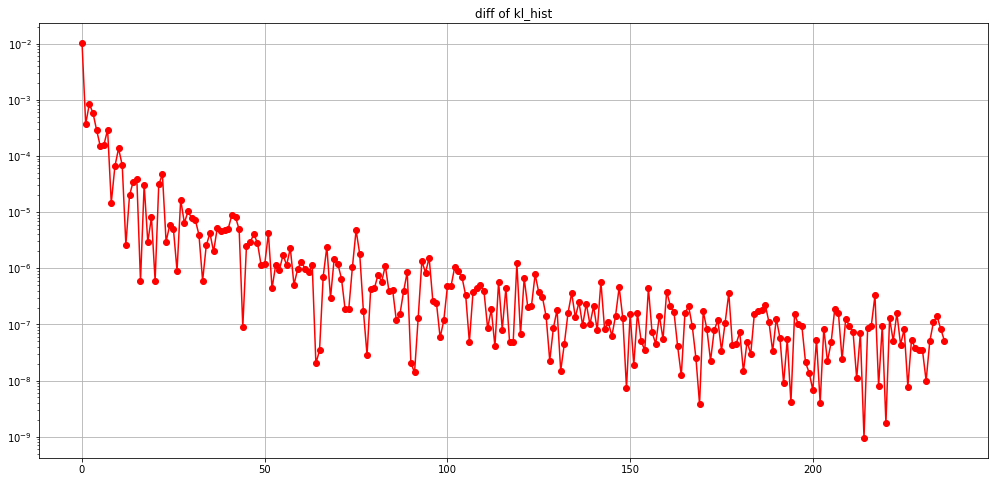

In [8]:
diff = np.diff(kl_hist)

plt.figure(figsize=(17,8))
plt.semilogy(diff[::-1], "ro-")
plt.title("diff of kl_hist")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

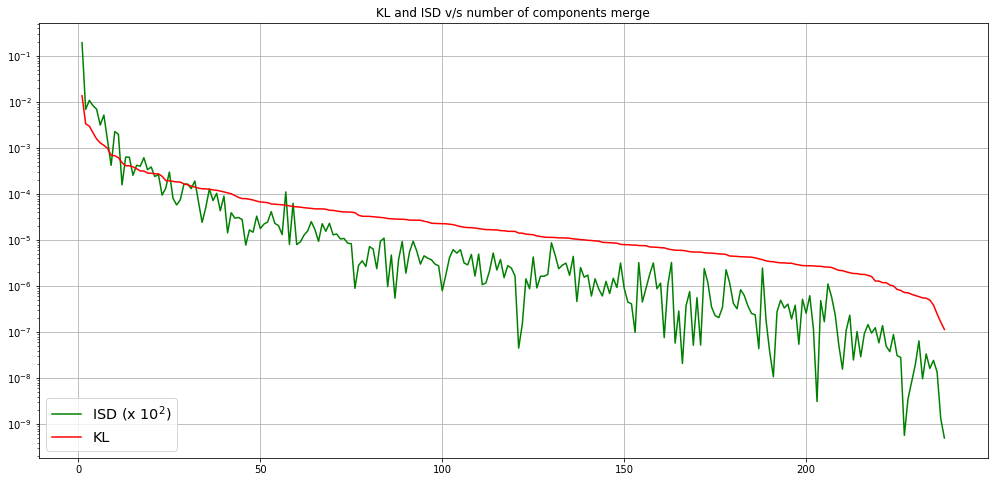

In [9]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [10]:
default_ncomp = ncomp_finder(kl_hist)
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01),\
         n_comp=IntSlider(min=1,max=20,value=default_ncomp), dims=fixed(data.shape), resolution=fixed(1),\
         n_levels=fixed(5))

<function graph.components_plot>

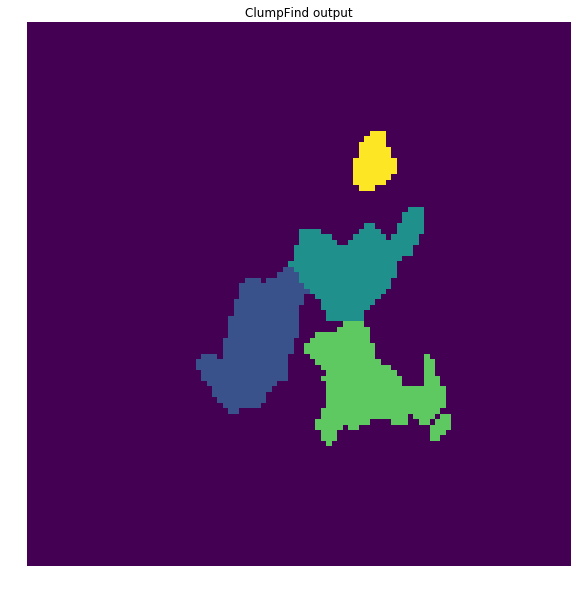

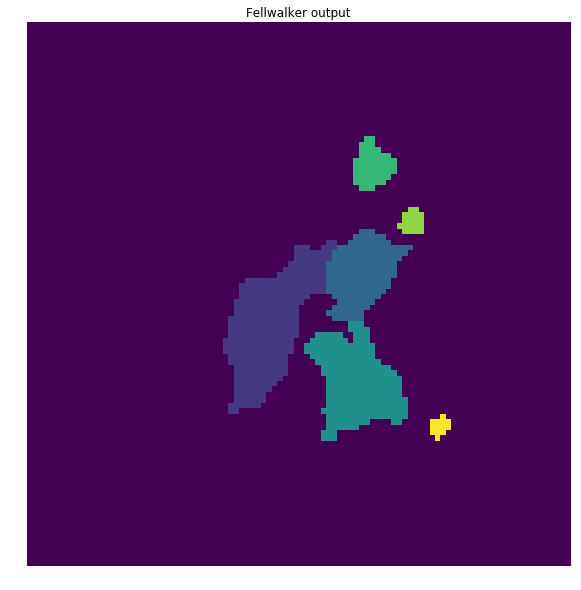

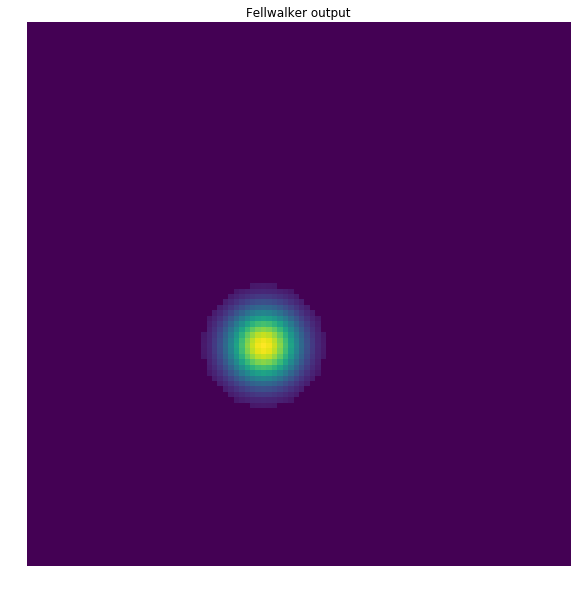

In [11]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf.T)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw.T)
plt.axis('off')
plt.show()

out_gc = gaussclumps(data, 0.9*base_level)
out_gc[out_gc==out_gc.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_gc.T)
plt.axis('off')
plt.show()

### Agglomeration with `ISD`

$$
d_{\textit{ISD}}(i,j) = \int_{\Omega} \left( (w_i \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_i, \Sigma_i) + w_j \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_j, \Sigma_j) ) - (w_m \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_m, \Sigma_m))  \right)^2 d\mathbf{x}
$$

In [ ]:
components_dict02, isd_hist02, kl_hist02 = gaussian_reduction(w, mu, sig, n_comp=1, metric='ISD', verbose=True)

In [ ]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict02), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

In [ ]:
ncomp = list(range(len(isd_hist02),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, isd_hist02, "b-", label='ISD')
plt.title("ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

### Agglomeration with normalized `ISD`

$$
d_{\textit{ISD}}(i,j) = \int_{\Omega} \left( (\frac{w_i}{w_m} \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_i, \Sigma_i) + \frac{w_j}{w_m} \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_j, \Sigma_j) ) - (\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_m, \Sigma_m))  \right)^2 d\mathbf{x}
$$

In [ ]:
components_dict03, isd_hist03, kl_hist03 = gaussian_reduction(w, mu, sig, n_comp=1, metric='ISD_', verbose=True)

In [ ]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict03), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

In [ ]:
ncomp = list(range(len(isd_hist03),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, isd_hist03, "g-", label='ISD')
plt.title("ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

### Agglomeration with `ISD`: Maray's Approach

In [ ]:
components_dict04, isd_hist = gaussian_reduction_(w, mu, sig, n_comp=1, verbose=True)

In [ ]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict04), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

### Agglomeration with `ISD`: Original William's Approach

In [ ]:
# WARNING: Running this cell takes an indetermined amount of time
components_dict05, isd_hist = gaussian_reduction__(w, mu, sig, n_comp=1, verbose=True)

## Conclusion: `Use the KL-divergence (upper bound), Runall approach. `

***
***

# `M100`

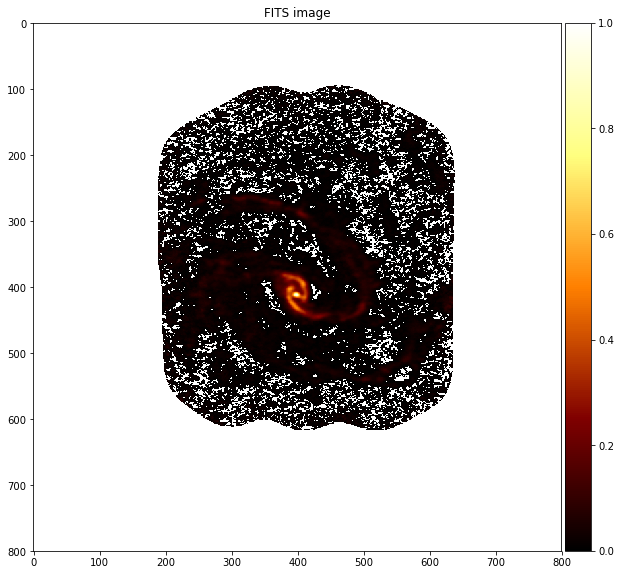

In [11]:
fits_path = '../data/images/M100_combine_CO_cube.image.mom0.pbcor.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [12]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

# Experiment: Generating an `ELM` instance

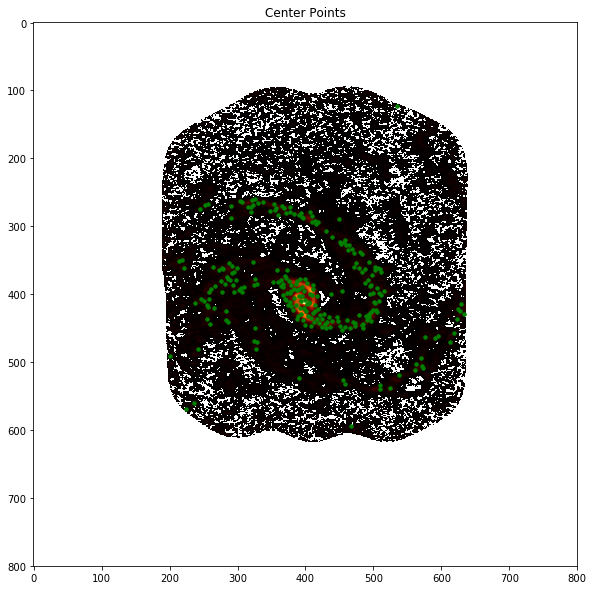

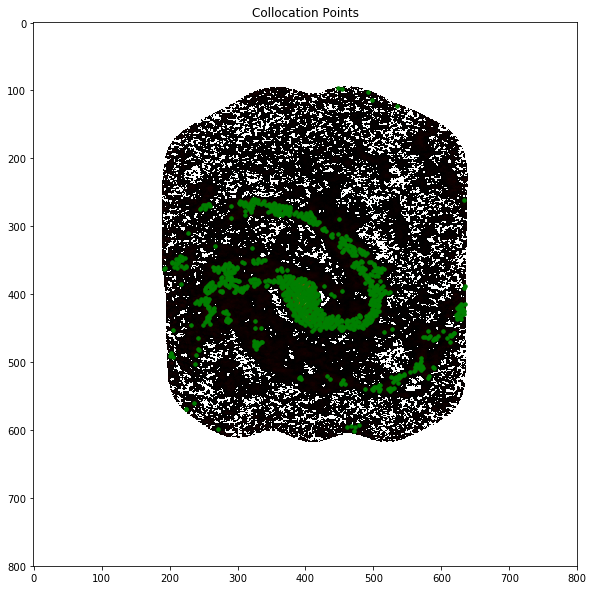

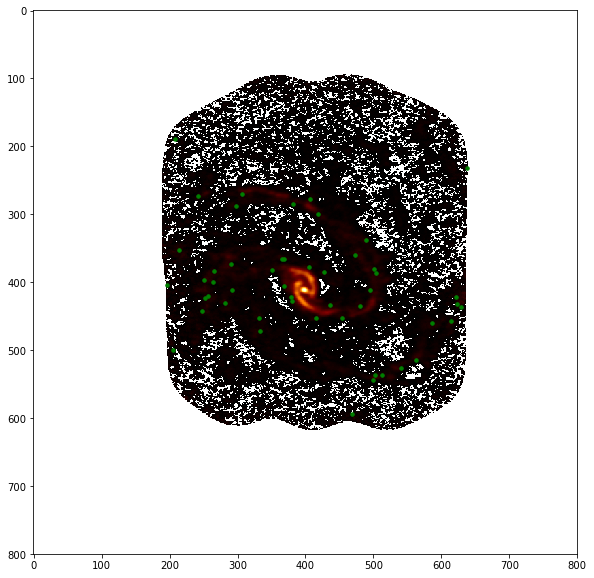

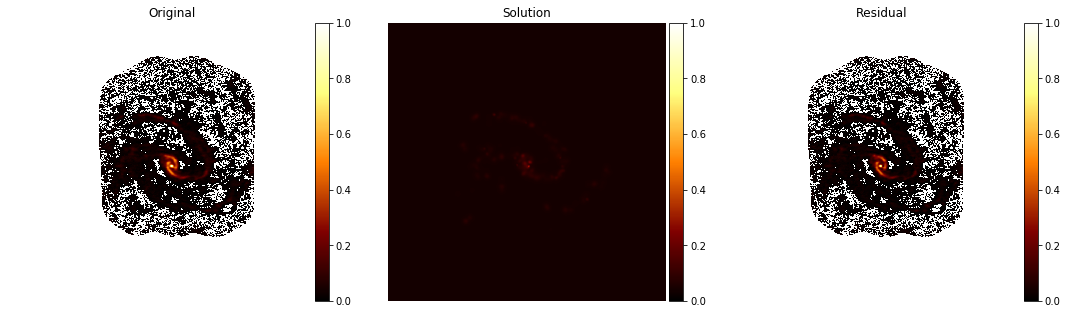

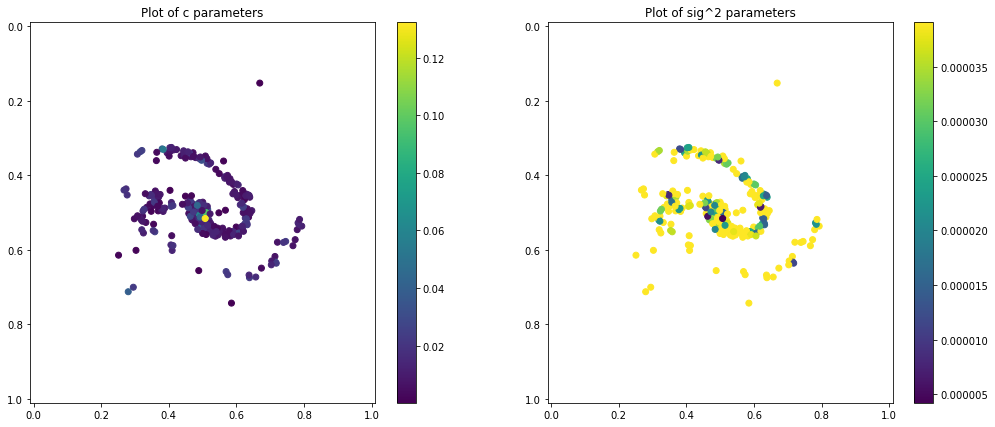

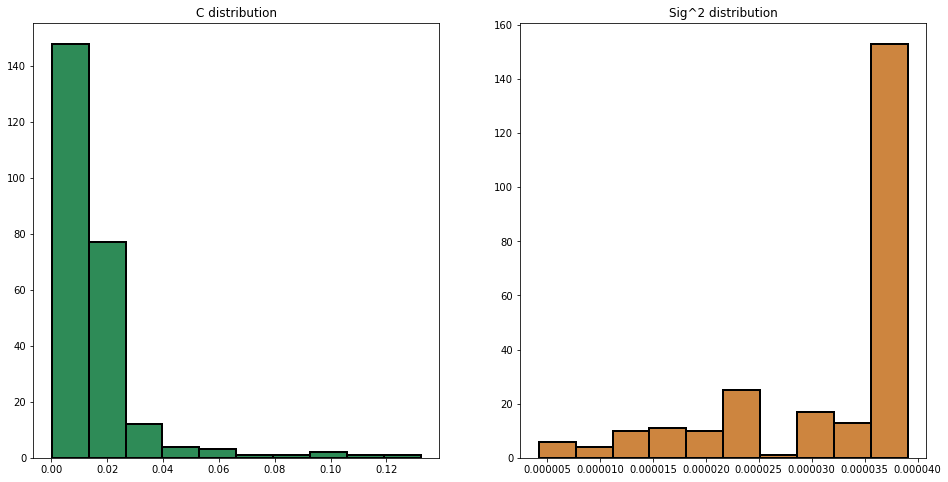

In [13]:
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm02 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100111

Residual stats:
Residual RMS: 0.030437389699780156
Residual Variance: 0.0009038230074451285
Flux Lost: 0.09926832312042892
Flux Addition: 0.052629678893004815
psi1(u-f): 1.122236128513609
Exceeded Pixels: 6216
Sharpness: 146.72854131887868
psi2(grad u): 145.47738332551464
Total elapsed time: 210.99681401252747 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.19227239404869345
Mean min distance between collocation and center points: 0.005298651586919914

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06806054427556954
Max min distance in the (standarized) parameters space: 0.4494346647045938


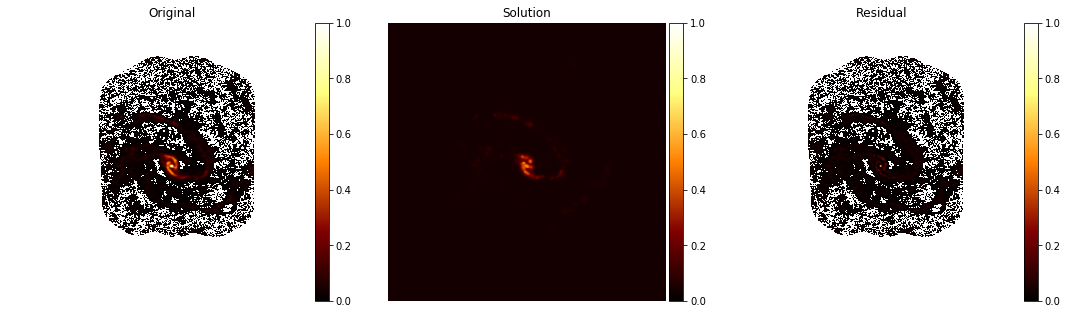

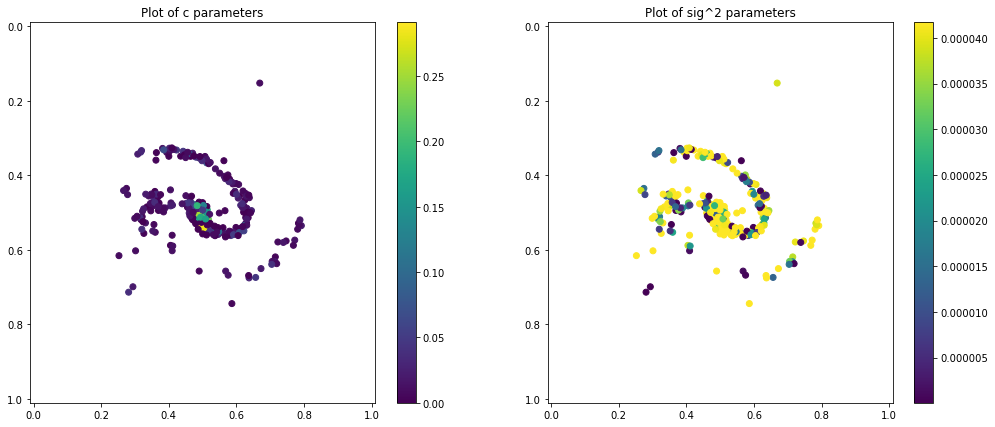

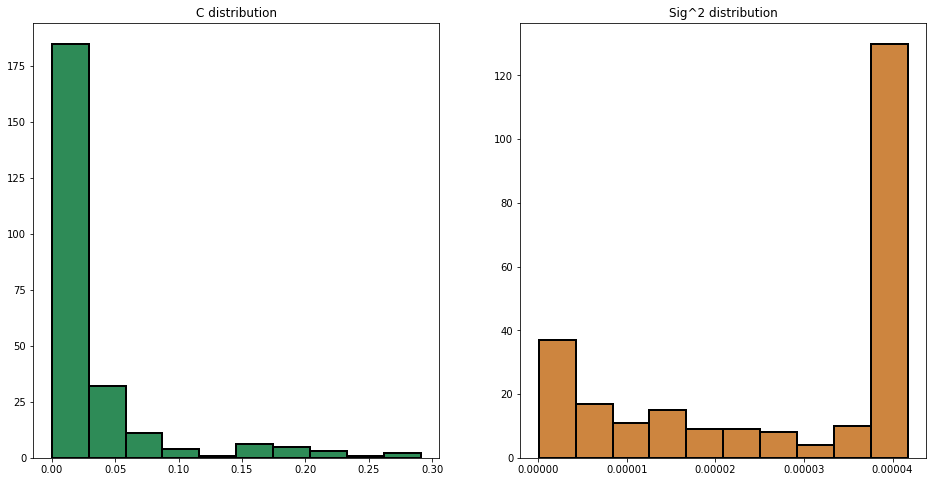

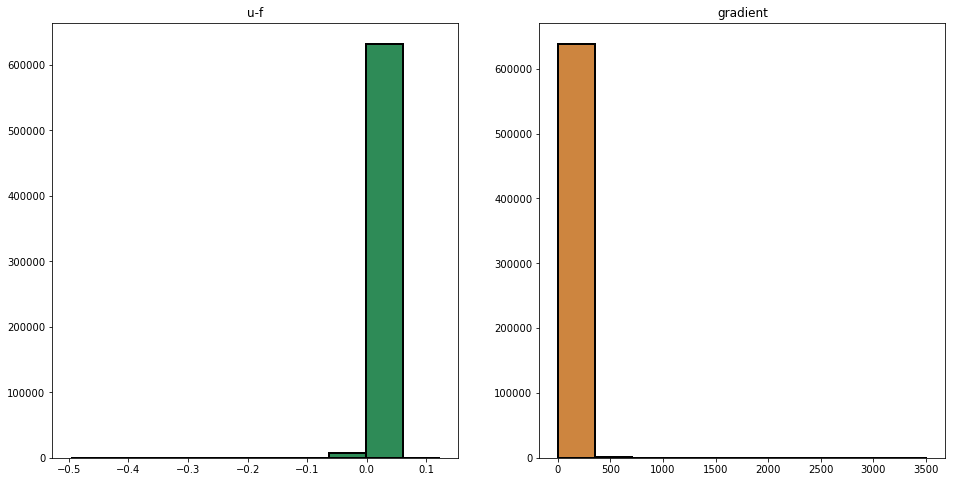

In [14]:
nfev = 100*(len(elm02.get_params())+1)
elm_solver(elm02, method='standard', max_nfev=nfev)

In [15]:
elm02.f0.min()

0.042536850658611264

In [16]:
xc, yc, c, sig = elm02.get_params_mapped()
xc

array([ 0.548125  ,  0.4778125 ,  0.34889861,  0.51292983,  0.65695313,
        0.51101562,  0.53976563,  0.39914063,  0.49509109,  0.46023437,
        0.34108984,  0.67391466,  0.33810431,  0.46066406,  0.36691406,
        0.69895178,  0.44894531,  0.49831971,  0.50167969,  0.41042807,
        0.45480469,  0.55105469,  0.33761719,  0.53685267,  0.34933594,
        0.49246094,  0.51339844,  0.54464844,  0.43527344,  0.56173828,
        0.61892578,  0.51876954,  0.55001953,  0.47970703,  0.55646209,
        0.33572266,  0.45041016,  0.35666021,  0.57896462,  0.45583984,
        0.35958984,  0.52615234,  0.48849609,  0.55880859,  0.47341772,
        0.49435726,  0.50713628,  0.48266011,  0.53274414,  0.48586884,
        0.63180664,  0.47415039,  0.51900398,  0.42477539,  0.54358244,
        0.52869501,  0.45563252,  0.44293992,  0.51510665,  0.46823165,
        0.56069886,  0.32809572,  0.35158423,  0.4946582 ,  0.53512695,
        0.48293945,  0.52786133,  0.36911133,  0.47708008,  0.57

In [17]:
elm02.prune()
xc, yc, c, sig = elm02.get_params_mapped()
w = elm02.get_w()
mu = np.vstack([xc, yc]).T

In [18]:
components_dict02, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 58 and 116 with 4.720602222033718e-09 KL dist and 4.859900328498124e-15 ISD dist
Merged components 37 and 167 with 5.1027658130079884e-09 KL dist and 1.0227368878548172e-14 ISD dist
Merged components 5 and 205 with 6.479415443131869e-09 KL dist and 1.5211535835227741e-13 ISD dist
Merged components 128 and 196 with 1.1185104751820823e-08 KL dist and 3.1534078334229236e-13 ISD dist
Merged components 13 and 114 with 1.1867342134950404e-08 KL dist and 5.013458327697923e-12 ISD dist
Merged components 46 and 121 with 1.4849472650238548e-08 KL dist and 2.5236097040863314e-14 ISD dist
Merged components 81 and 143 with 1.535234836424645e-08 KL dist and 7.796095577699207e-12 ISD dist
Merged components 26 and 145 with 1.5393964625892405e-08 KL dist and 4.0918291801616675e-14 ISD dist
Merged components 4 and 103 with 1.9533036951899403e-08 KL dist and 6.878744671307349e-13 ISD dist
Merged components 61 and 110 with 1.9959641062136904e-08 KL dist and 9.890628197997756e-12 ISD dist

Merged components 33 and 89 with 1.4335976373517143e-06 KL dist and 6.12774868202222e-09 ISD dist
Merged components 89 and 99 with 1.4411513726825598e-06 KL dist and 3.4782523281589716e-10 ISD dist
Merged components 9 and 50 with 1.4750468280876369e-06 KL dist and 1.492076249339089e-09 ISD dist
Merged components 20 and 39 with 1.514729466084916e-06 KL dist and 6.570614735825614e-10 ISD dist
Merged components 37 and 69 with 1.5298369214622934e-06 KL dist and 5.441325506638321e-10 ISD dist
Merged components 49 and 81 with 1.5538468721615665e-06 KL dist and 2.3214813521761386e-09 ISD dist
Merged components 77 and 90 with 1.566398361617827e-06 KL dist and 1.403292683227128e-09 ISD dist
Merged components 59 and 76 with 1.6046620024066759e-06 KL dist and 2.329606362968284e-09 ISD dist
Merged components 26 and 120 with 1.640570833220872e-06 KL dist and 2.879262519315221e-10 ISD dist
Merged components 25 and 80 with 1.6841073518186436e-06 KL dist and 3.6657344548328988e-09 ISD dist
Merged comp

Merged components 8 and 27 with 1.5710595652690932e-05 KL dist and 1.5573750362913613e-08 ISD dist
Merged components 6 and 26 with 1.6373963048920396e-05 KL dist and 7.597517572873597e-08 ISD dist
Merged components 4 and 17 with 1.6788544650215854e-05 KL dist and 1.093199883800286e-07 ISD dist
Merged components 5 and 23 with 1.7642373904427227e-05 KL dist and 3.699198184179855e-08 ISD dist
Merged components 0 and 21 with 1.836890271772007e-05 KL dist and 1.214514127961008e-07 ISD dist
Merged components 20 and 24 with 1.9455005537279683e-05 KL dist and 6.529756659993543e-08 ISD dist
Merged components 17 and 20 with 1.9629379780584217e-05 KL dist and 7.962233919799531e-08 ISD dist
Merged components 1 and 25 with 2.1600956494332126e-05 KL dist and 1.279127369056039e-07 ISD dist
Merged components 6 and 21 with 2.195162411857989e-05 KL dist and 4.114845168432761e-08 ISD dist
Merged components 16 and 24 with 2.2319754278918e-05 KL dist and 1.022388580198934e-07 ISD dist
Merged components 8 a

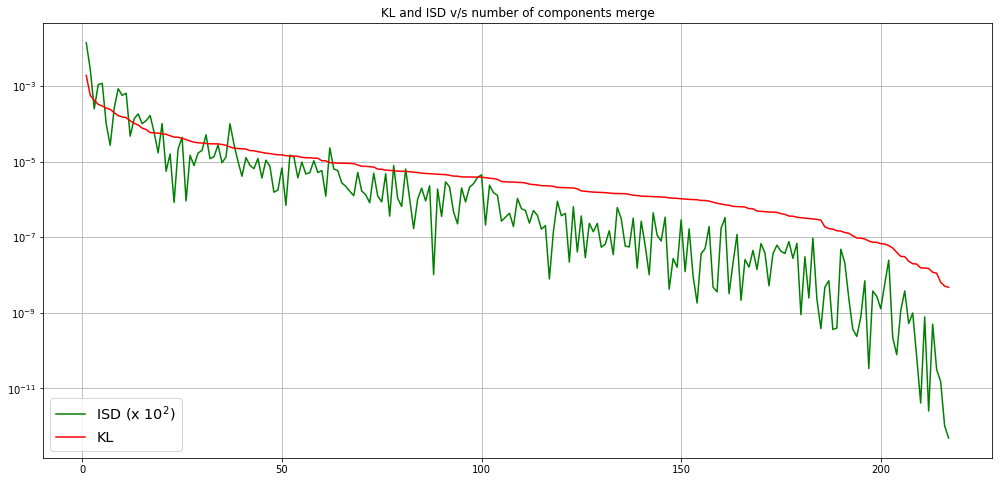

In [19]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [20]:
default_ncomp = ncomp_finder(kl_hist)
interact(components_plot, elm=fixed(elm02), data=fixed(data), components_dict=fixed(components_dict02),\
         n_comp=IntSlider(min=1,max=20,value=default_ncomp), dims=fixed(data.shape), resolution=fixed(1),\
         n_levels=fixed(5))

<function graph.components_plot>

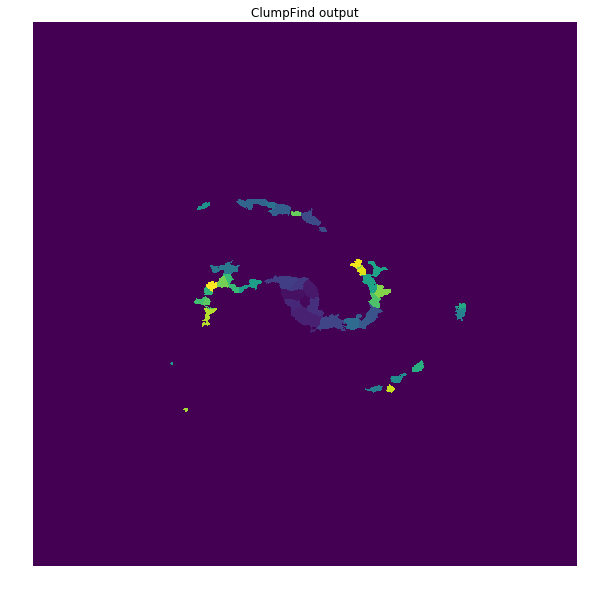

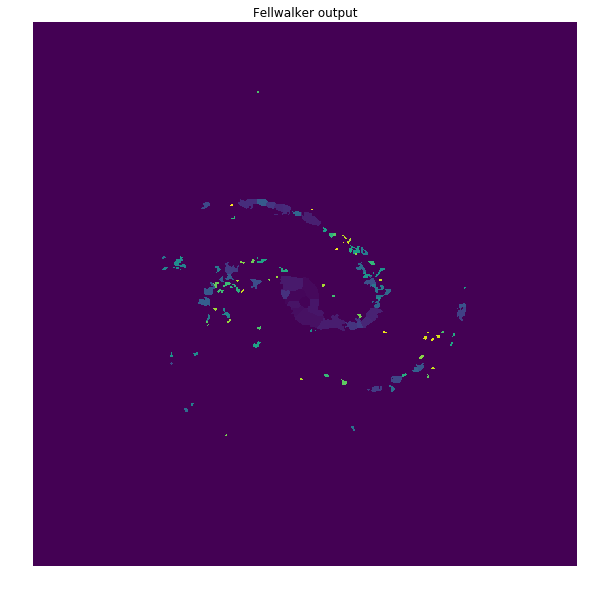

In [22]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf.T)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw.T)
plt.axis('off')
plt.show()

***
***

# `NGC3265`

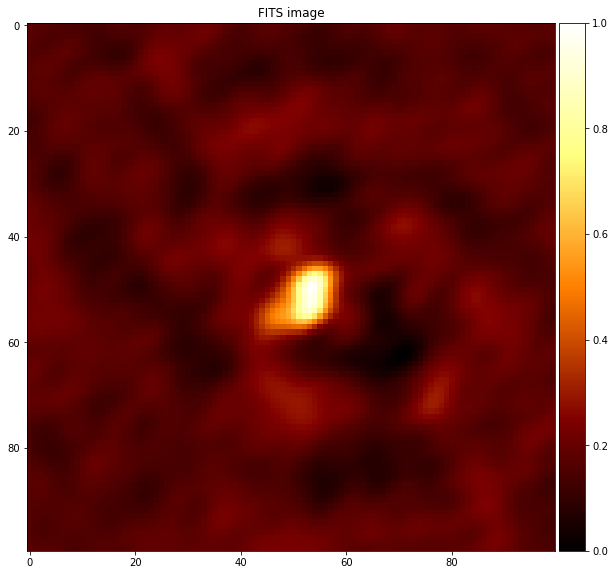

In [21]:
"""
Loading data
"""

fits_path = '../data/images/result-ngc3256_cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [22]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

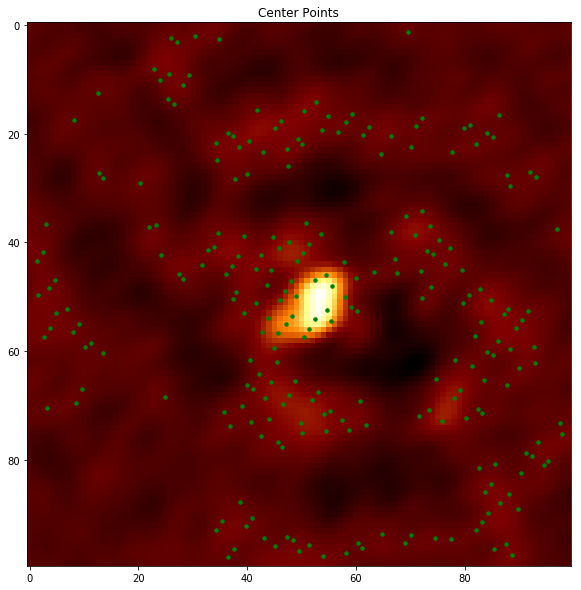

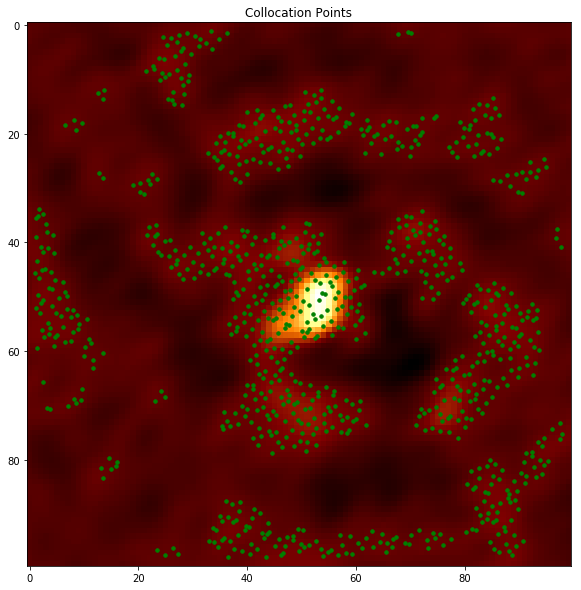

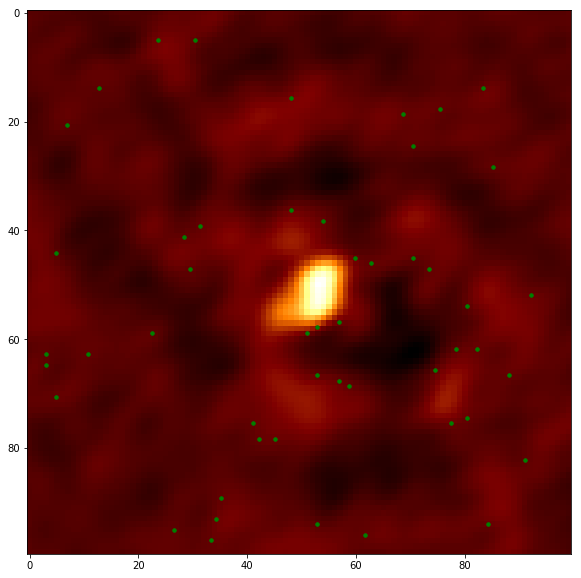

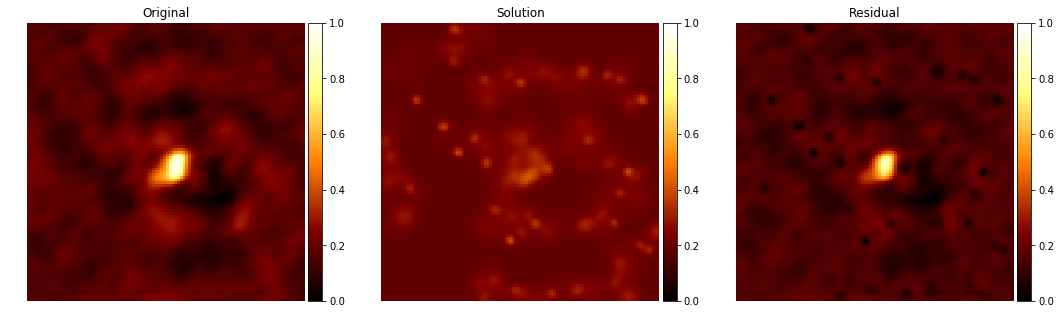

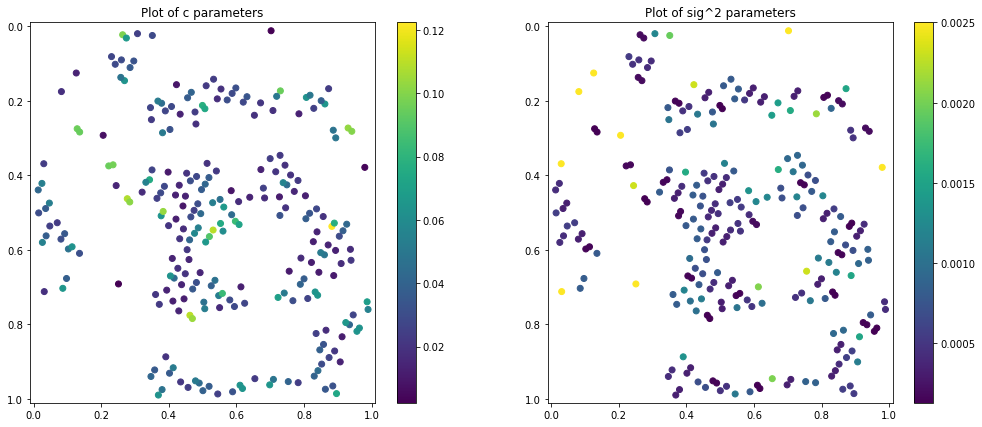

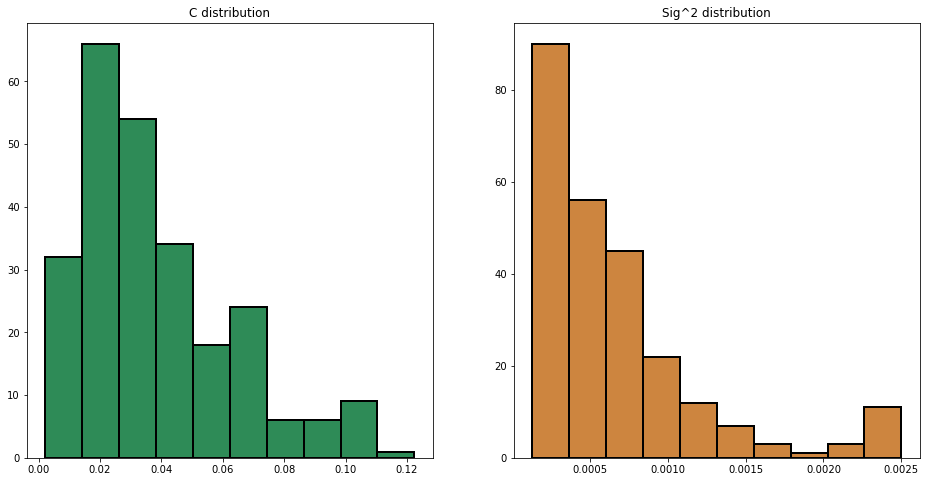

In [23]:
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm03 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100112

Residual stats:
Residual RMS: 0.005465719096929585
Residual Variance: 2.920581146946814e-05
Flux Lost: 0.009417370600032084
Flux Addition: 0.00593439885793406
psi1(u-f): 0.004857095303185438
Exceeded Pixels: 1269
Sharpness: 55.43016412342585
psi2(grad u): 54.07436485720715
Total elapsed time: 226.13519287109375 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.14294354058000602
Mean min distance between collocation and center points: 0.015936534660185686

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.07879011075881405
Max min distance in the (standarized) parameters space: 0.3872589959149791


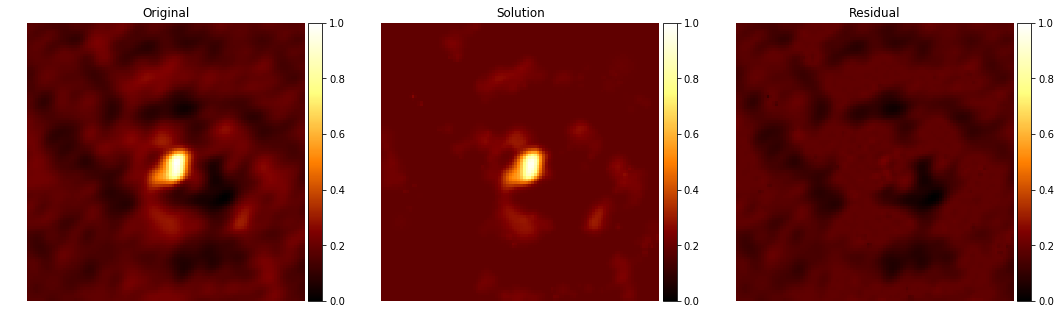

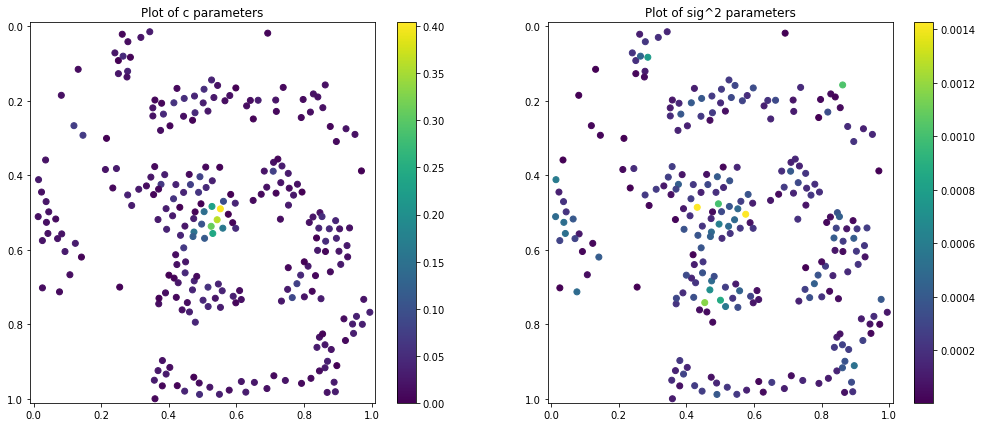

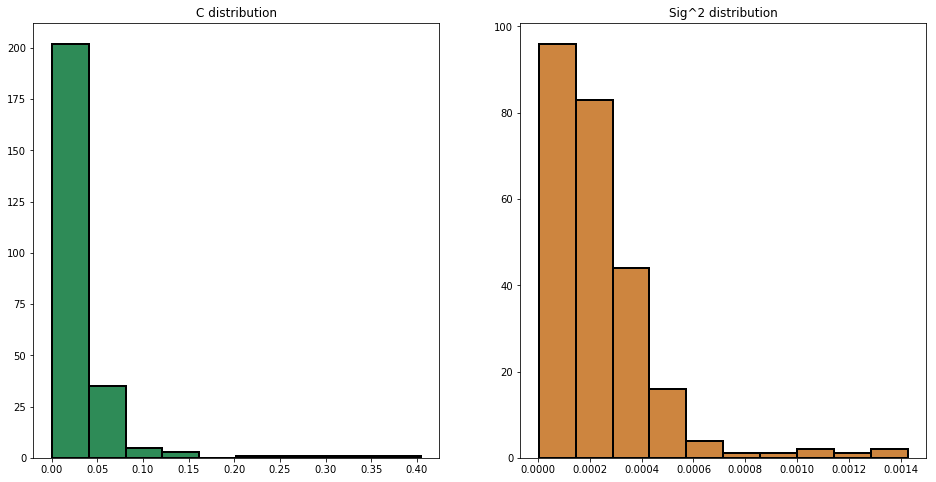

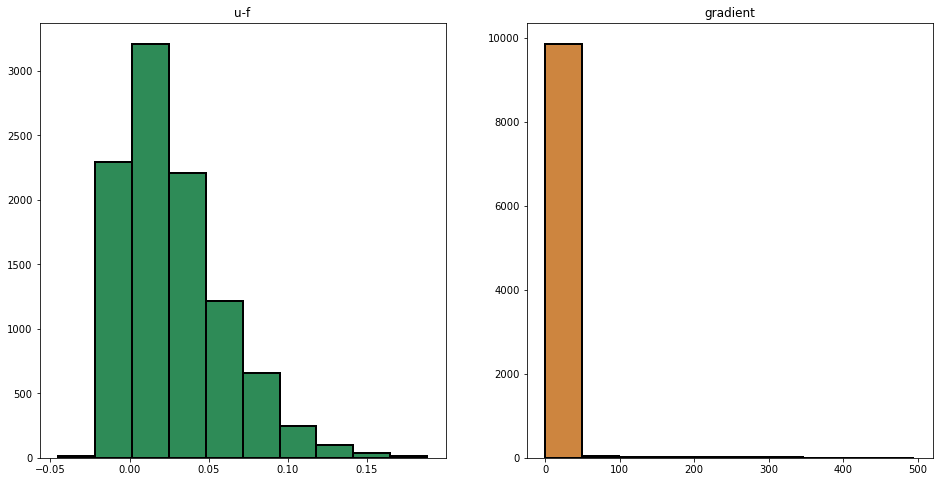

In [24]:
nfev = 100*(len(elm03.get_params())+1)
elm_solver(elm03, method='standard', max_nfev=nfev)

In [25]:
elm03.prune()
xc, yc, c, sig = elm03.get_params_mapped()
w = elm03.get_w()
mu = np.vstack([xc, yc]).T

In [26]:
components_dict03, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 97 and 124 with 6.197926030928474e-07 KL dist and 5.341422513436952e-11 ISD dist
Merged components 34 and 208 with 6.440818800740669e-07 KL dist and 3.4838077978760995e-11 ISD dist
Merged components 162 and 209 with 8.122238972531597e-07 KL dist and 8.311368702868931e-11 ISD dist
Merged components 158 and 213 with 8.968208134503941e-07 KL dist and 3.6454211882903113e-10 ISD dist
Merged components 45 and 125 with 9.056077438204286e-07 KL dist and 2.5034498525857745e-10 ISD dist
Merged components 69 and 152 with 1.0496339728871438e-06 KL dist and 8.6227360912713e-10 ISD dist
Merged components 114 and 144 with 1.1913386030608499e-06 KL dist and 8.048878141520811e-10 ISD dist
Merged components 96 and 114 with 1.248078852956998e-06 KL dist and 7.188642750045766e-10 ISD dist
Merged components 50 and 208 with 1.3765249117305792e-06 KL dist and 1.1435063876178226e-10 ISD dist
Merged components 61 and 140 with 1.4259457033681252e-06 KL dist and 4.079357631997293e-10 ISD dist
M

Merged components 26 and 122 with 1.8650287298130753e-05 KL dist and 3.659533556163098e-08 ISD dist
Merged components 36 and 103 with 1.870427751735754e-05 KL dist and 3.8860907385864456e-08 ISD dist
Merged components 0 and 24 with 1.8975961810328227e-05 KL dist and 2.6273661211136225e-08 ISD dist
Merged components 63 and 100 with 1.908968905113941e-05 KL dist and 6.185552794616897e-08 ISD dist
Merged components 22 and 64 with 1.945579706029145e-05 KL dist and 1.9719255583572737e-08 ISD dist
Merged components 61 and 129 with 2.0478955931106505e-05 KL dist and 3.975213140306245e-08 ISD dist
Merged components 35 and 128 with 2.054271202673501e-05 KL dist and 7.865564880176129e-08 ISD dist
Merged components 4 and 15 with 2.091431543176607e-05 KL dist and 3.3457343797812e-08 ISD dist
Merged components 74 and 97 with 2.0981712414955907e-05 KL dist and 1.442453746459904e-09 ISD dist
Merged components 48 and 76 with 2.1168744643297095e-05 KL dist and 3.159571616891506e-08 ISD dist
Merged comp

Merged components 4 and 13 with 0.0001554008691492339 KL dist and 6.226391609124056e-07 ISD dist
Merged components 2 and 3 with 0.00016202484539170866 KL dist and 2.1272085338818825e-07 ISD dist
Merged components 3 and 41 with 0.000164870798280454 KL dist and 8.109040916421279e-07 ISD dist
Merged components 2 and 22 with 0.00017230892703384176 KL dist and 1.1202016329250352e-06 ISD dist
Merged components 8 and 9 with 0.00017651215573198762 KL dist and 4.2315247222487115e-07 ISD dist
Merged components 4 and 14 with 0.00018087638125279968 KL dist and 6.059494636270709e-07 ISD dist
Merged components 15 and 21 with 0.00018932182984480756 KL dist and 7.56147855757576e-07 ISD dist
Merged components 8 and 22 with 0.00019717482577537754 KL dist and 1.5141719049082287e-06 ISD dist
Merged components 13 and 21 with 0.0002155925138096937 KL dist and 8.28021302421049e-07 ISD dist
Merged components 2 and 30 with 0.00022335551615090777 KL dist and 1.5138622281741218e-06 ISD dist
Merged components 11 

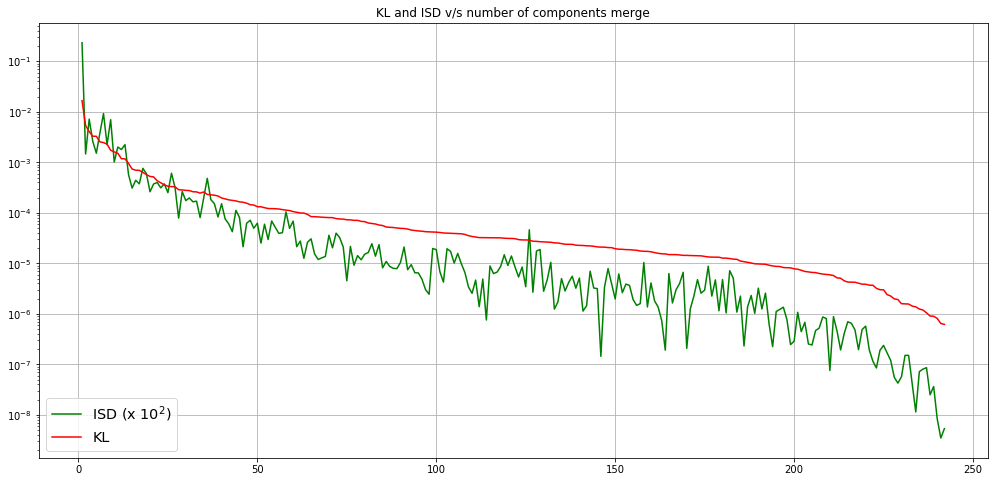

In [27]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [29]:
default_ncomp = ncomp_finder(kl_hist)
interact(components_plot, elm=fixed(elm03), data=fixed(data), components_dict=fixed(components_dict03),\
         n_comp=IntSlider(min=1,max=20,value=default_ncomp), dims=fixed(data.shape), resolution=fixed(1),\
         n_levels=fixed(5))

<function graph.components_plot>

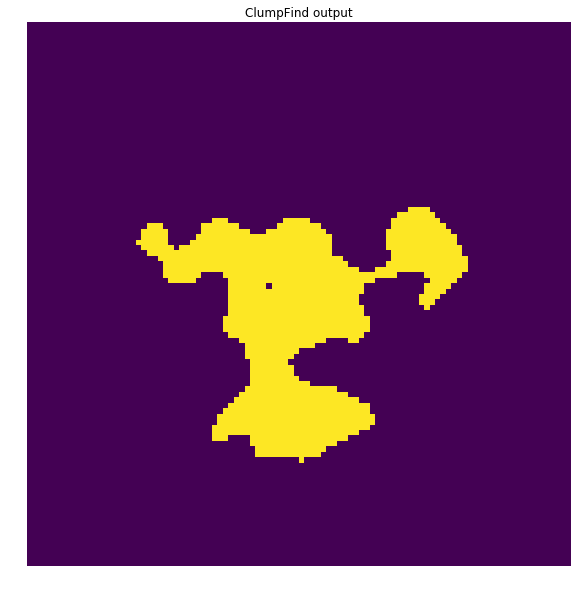

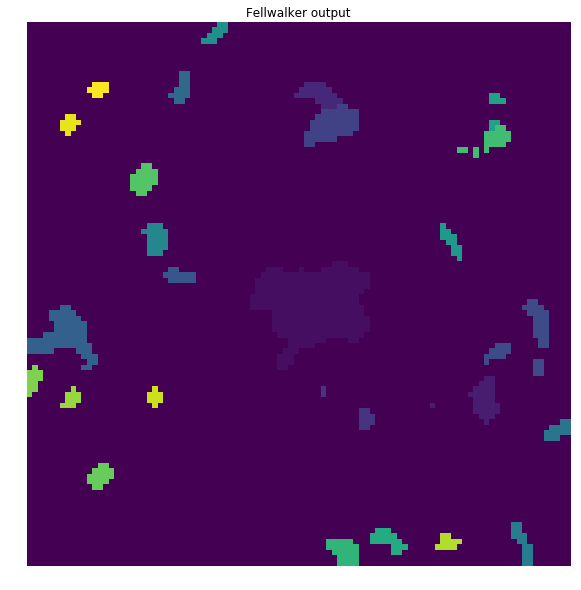

In [31]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf.T)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw.T)
plt.axis('off')
plt.show()

***
***
# `Antennae North`

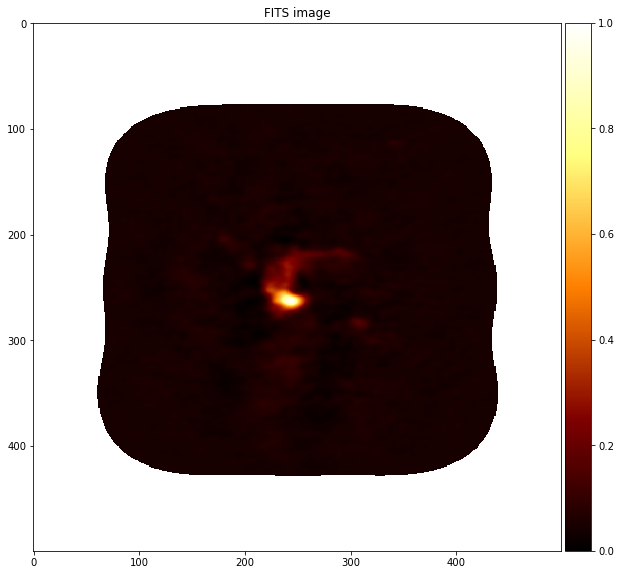

In [30]:
fits_path = '../data/images/Antennae_North.CO3_2Line.Clean.pcal1.image.mom0.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [31]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

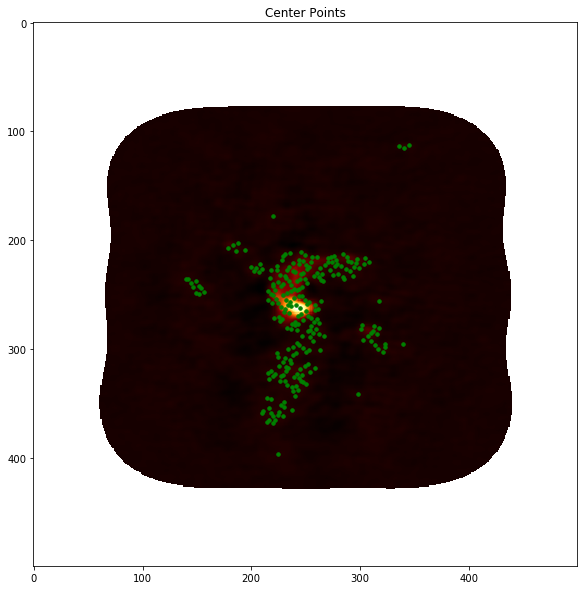

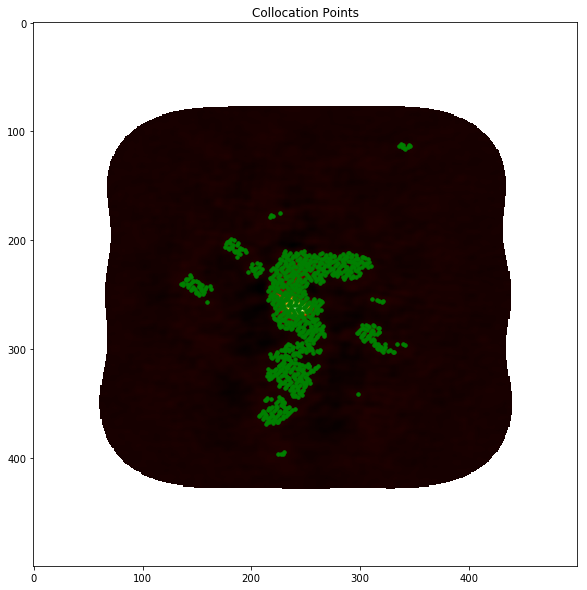

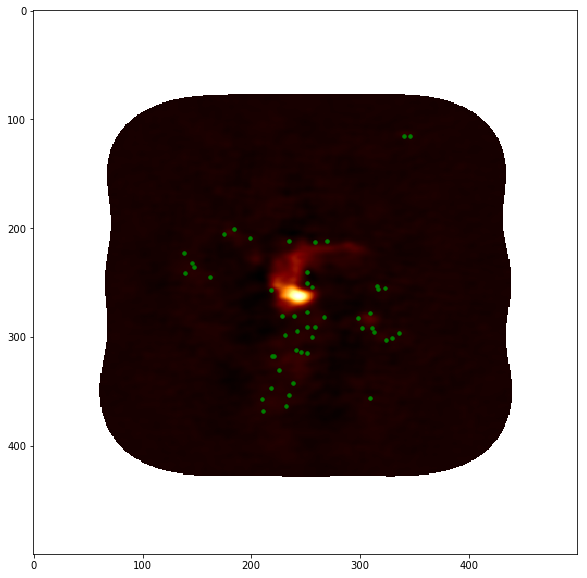

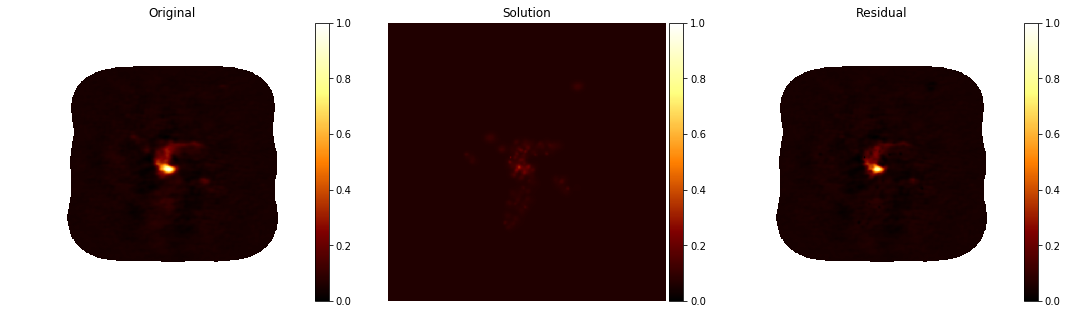

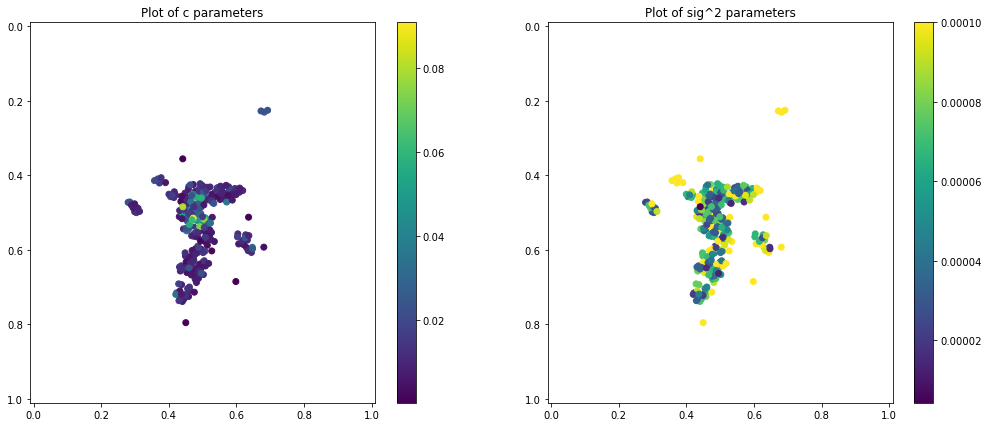

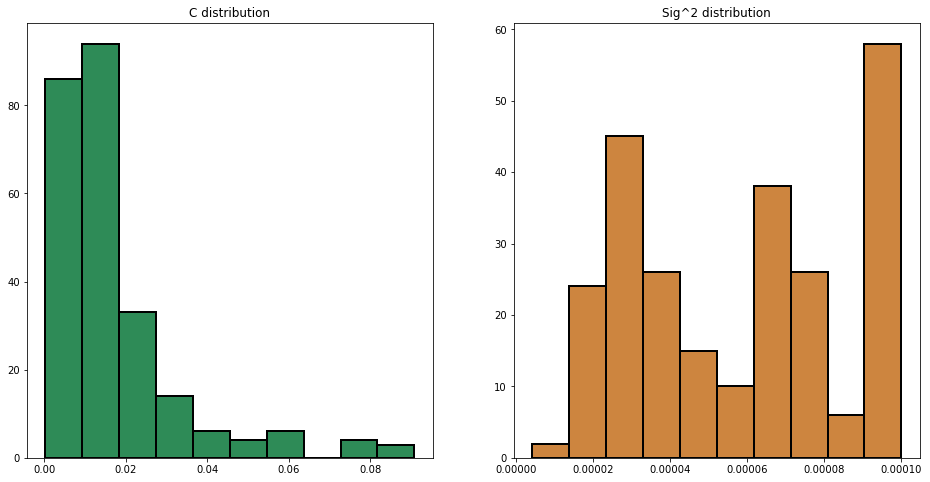

In [32]:
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm04 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100108

Residual stats:
Residual RMS: 0.007323018698032352
Residual Variance: 5.331542932036504e-05
Flux Lost: 0.01819755870931587
Flux Addition: 0.01413462600056698
psi1(u-f): 0.02414638332232715
Exceeded Pixels: 3504
Sharpness: 93.89290303534662
psi2(grad u): 92.23690427589213
Total elapsed time: 251.23926186561584 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.02046733423669602
Mean min distance between collocation and center points: 0.004714256360474031

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06644069841756589
Max min distance in the (standarized) parameters space: 0.3448759502223117


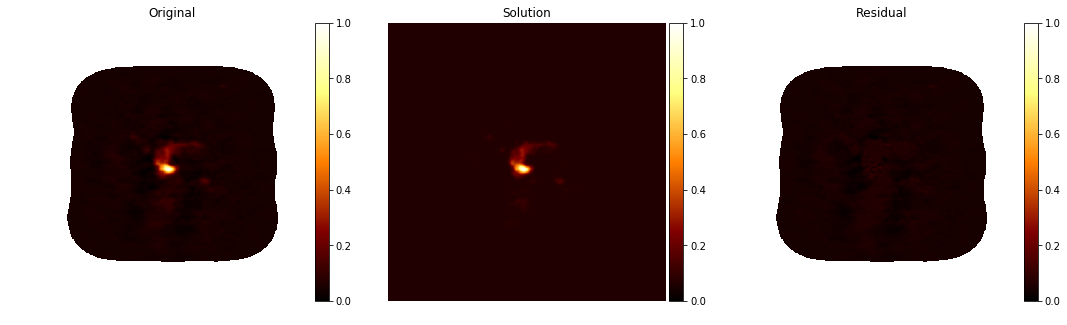

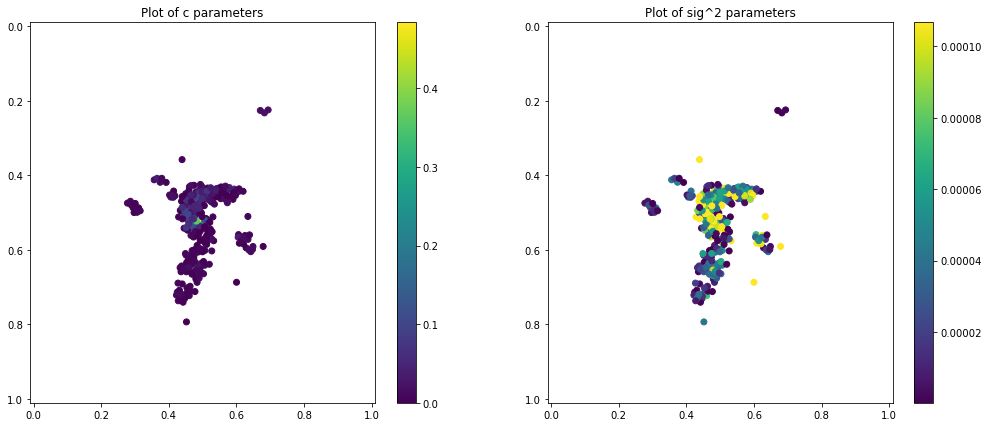

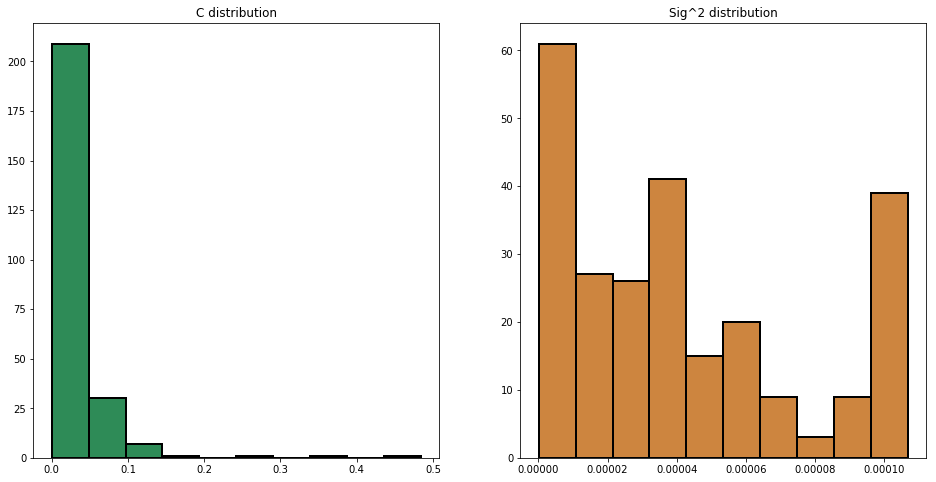

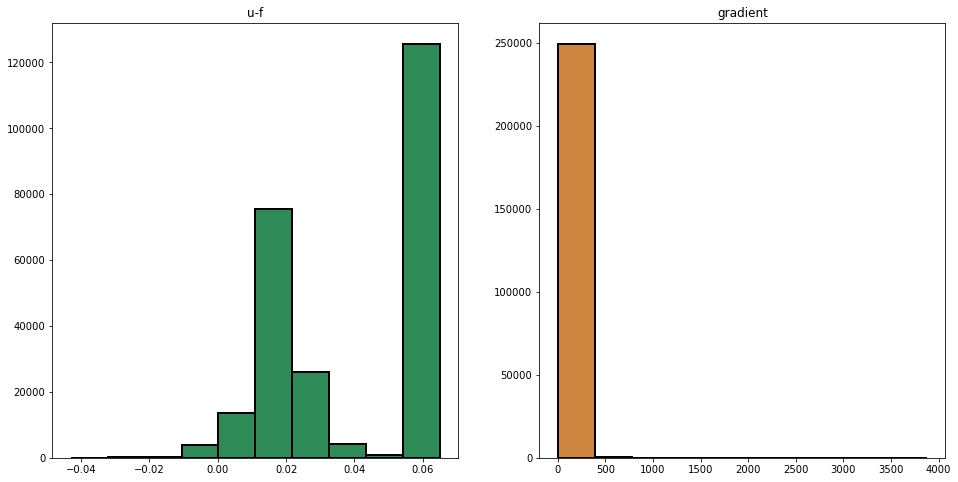

In [33]:
nfev = 100*(len(elm04.get_params())+1)
elm_solver(elm04, method='standard', max_nfev=nfev)

In [34]:
elm04.prune()
xc, yc, c, sig = elm04.get_params_mapped()
w = elm04.get_w()
mu = np.vstack([xc, yc]).T

In [35]:
components_dict04, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 140 and 190 with 5.916877530378511e-09 KL dist and 6.781715124434579e-14 ISD dist
Merged components 24 and 102 with 7.873401090006137e-09 KL dist and 8.458922268084093e-14 ISD dist
Merged components 156 and 206 with 8.252212182579925e-09 KL dist and 7.790812494849644e-14 ISD dist
Merged components 14 and 116 with 1.0249640683112458e-08 KL dist and 2.079029658582343e-12 ISD dist
Merged components 191 and 216 with 1.230390011112356e-08 KL dist and 8.88602367796596e-14 ISD dist
Merged components 7 and 177 with 1.4849786601478938e-08 KL dist and 1.225017836925748e-12 ISD dist
Merged components 85 and 214 with 1.628673359436154e-08 KL dist and 3.5817929206444763e-12 ISD dist
Merged components 63 and 111 with 1.7912813941767163e-08 KL dist and 1.3660317532387524e-11 ISD dist
Merged components 81 and 132 with 1.8125284172612182e-08 KL dist and 9.528047877646076e-12 ISD dist
Merged components 72 and 147 with 2.1024607841957448e-08 KL dist and 4.666601075882697e-12 ISD dist
Me

Merged components 53 and 72 with 9.100241286177674e-07 KL dist and 1.65550413358628e-11 ISD dist
Merged components 100 and 104 with 9.232038228754954e-07 KL dist and 5.708520453466398e-10 ISD dist
Merged components 68 and 115 with 9.58178484488975e-07 KL dist and 4.24431435748858e-10 ISD dist
Merged components 37 and 85 with 9.843305585027464e-07 KL dist and 1.0687050503599036e-10 ISD dist
Merged components 89 and 97 with 1.046191331854704e-06 KL dist and 9.986095537691825e-10 ISD dist
Merged components 22 and 117 with 1.1051286027569773e-06 KL dist and 1.7259941654404534e-09 ISD dist
Merged components 79 and 112 with 1.1093145835785123e-06 KL dist and 4.9246248839580635e-11 ISD dist
Merged components 5 and 81 with 1.1989630623419895e-06 KL dist and 1.2667561909924218e-08 ISD dist
Merged components 43 and 107 with 1.2036818253935438e-06 KL dist and 1.7041179169069855e-09 ISD dist
Merged components 72 and 105 with 1.2550284239056003e-06 KL dist and 1.5022046424818183e-10 ISD dist
Merged

Merged components 2 and 37 with 1.5424220738120236e-05 KL dist and 7.879763860421872e-09 ISD dist
Merged components 5 and 13 with 1.5557880025077685e-05 KL dist and 5.0972307233395736e-08 ISD dist
Merged components 0 and 18 with 1.6511228978108045e-05 KL dist and 3.565570255289479e-09 ISD dist
Merged components 1 and 19 with 1.674177397521635e-05 KL dist and 1.4633278562662693e-07 ISD dist
Merged components 3 and 7 with 1.8022815325568586e-05 KL dist and 3.6200415472411546e-08 ISD dist
Merged components 9 and 19 with 1.8307617660261166e-05 KL dist and 1.6062651595410674e-07 ISD dist
Merged components 17 and 18 with 1.8313077992741198e-05 KL dist and 3.474736509435591e-08 ISD dist
Merged components 12 and 28 with 1.8960832039888154e-05 KL dist and 6.476476245705016e-08 ISD dist
Merged components 11 and 23 with 1.900097203921526e-05 KL dist and 1.7993695716924426e-07 ISD dist
Merged components 1 and 11 with 1.9337480203447937e-05 KL dist and 9.296329284746074e-08 ISD dist
Merged componen

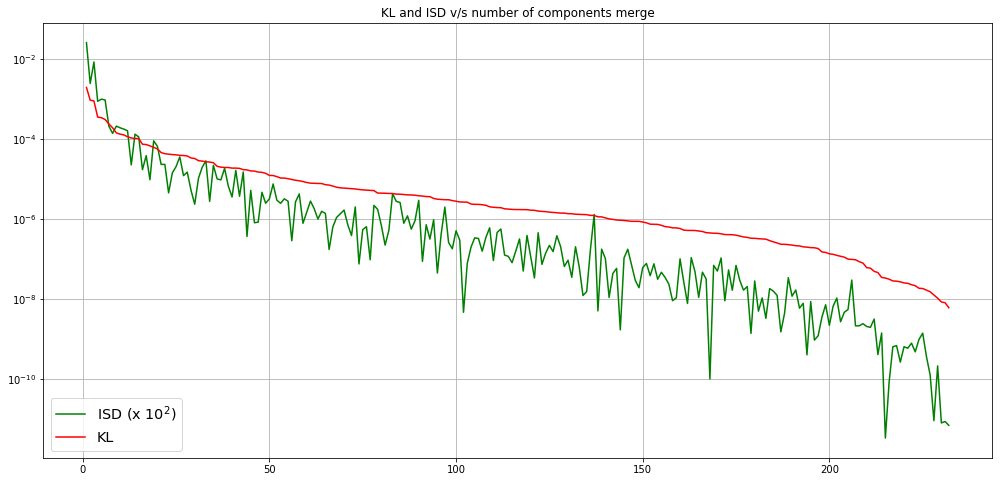

In [36]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [37]:
default_ncomp = ncomp_finder(kl_hist)
interact(components_plot, elm=fixed(elm04), data=fixed(data), components_dict=fixed(components_dict04),\
         n_comp=IntSlider(min=1,max=20,value=default_ncomp), dims=fixed(data.shape), resolution=fixed(1),\
         n_levels=fixed(5))

<function graph.components_plot>

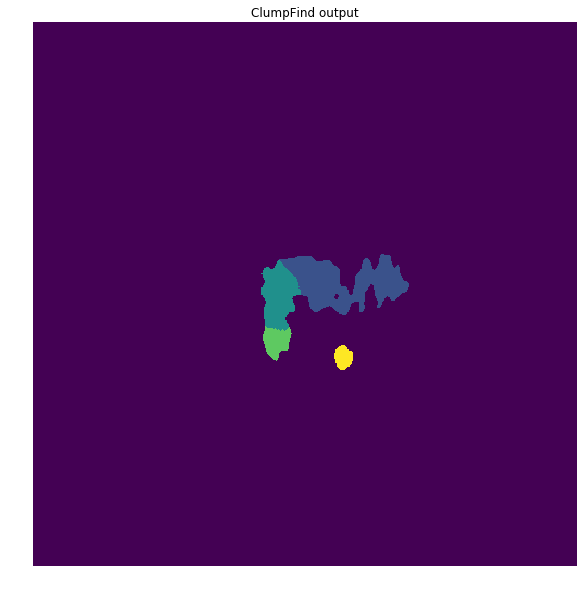

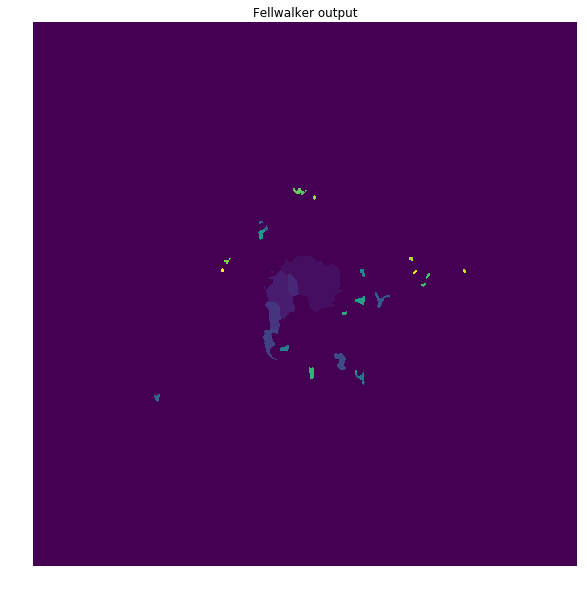

In [40]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw)
plt.axis('off')
plt.show()

***
***
# TWHydra_CO3_2

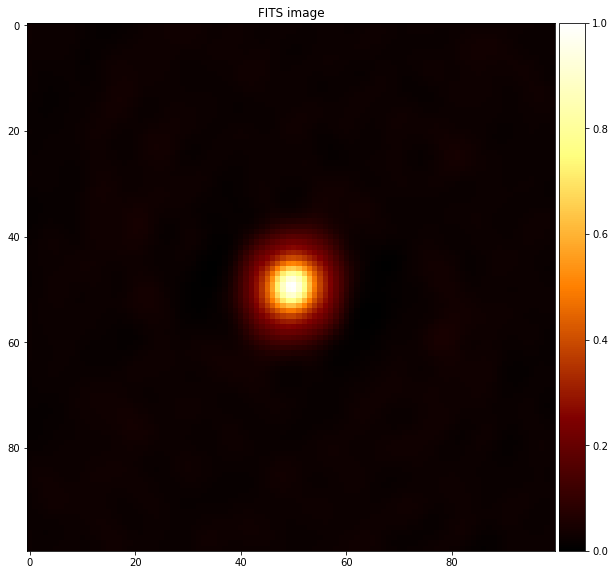

In [38]:
fits_path = '../data/images/TWHydra_CO3_2line.image.mom0.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [39]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

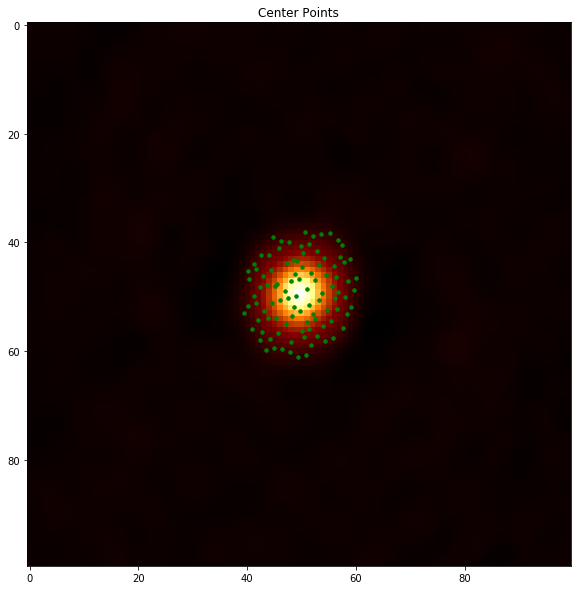

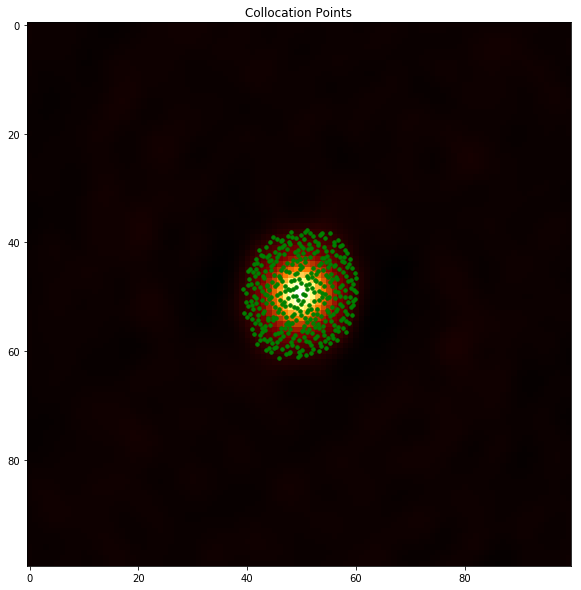

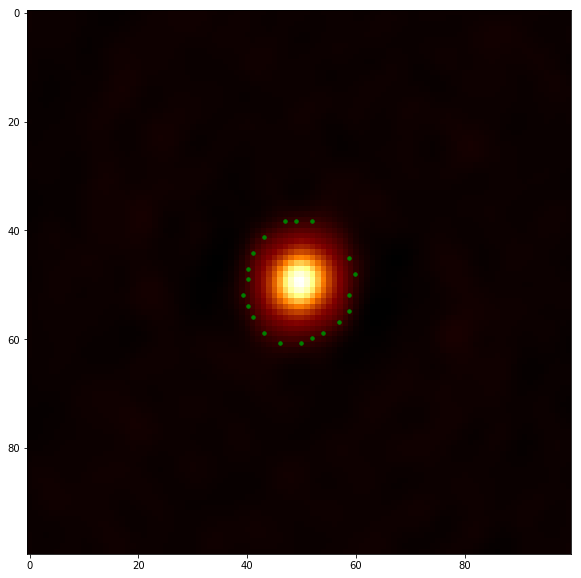

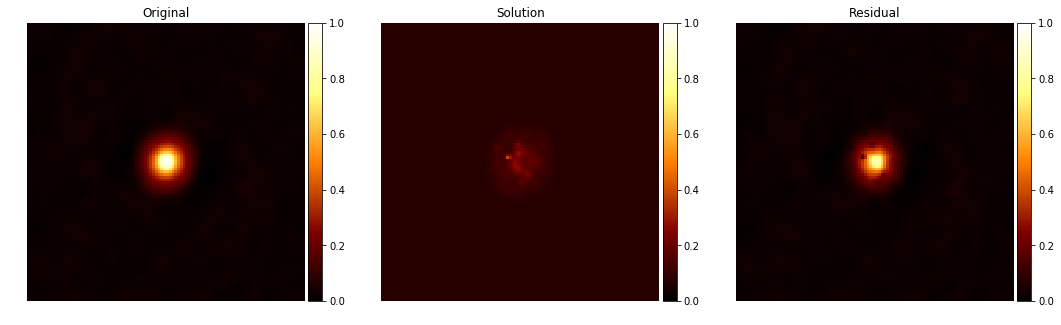

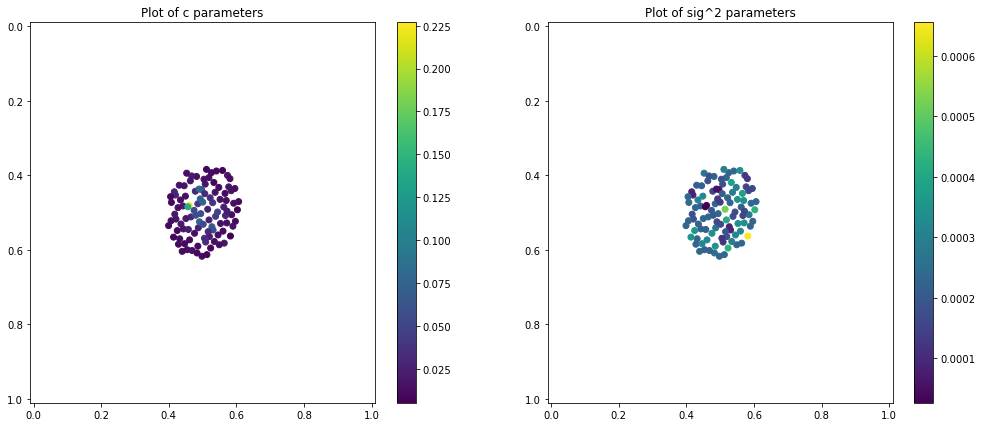

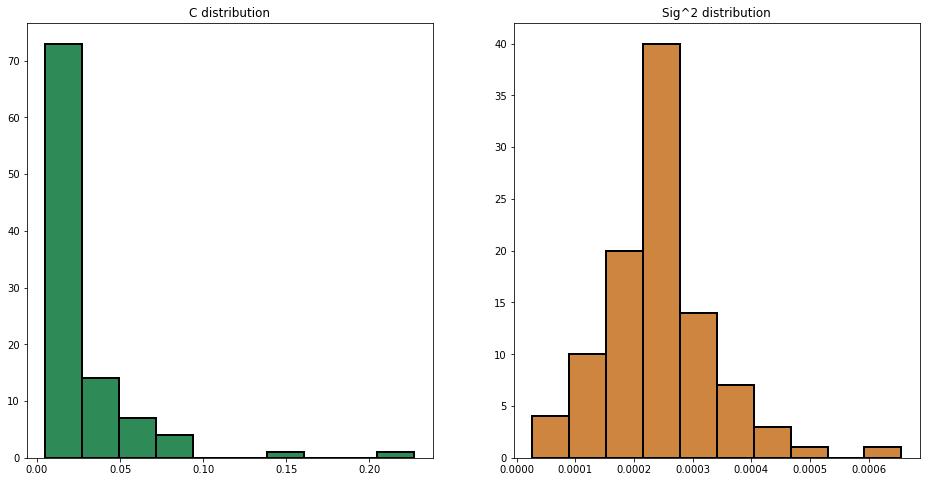

In [40]:
Nc = 100
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm05 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 40100.
nfev: 40110

Residual stats:
Residual RMS: 0.004725811173456893
Residual Variance: 2.2284575475572494e-05
Flux Lost: 0.004565006250243686
Flux Addition: 0.003777220913784295
psi1(u-f): 0.002254583211596921
Exceeded Pixels: 227
Sharpness: 27.078598644387856
psi2(grad u): 26.054136196367384
Total elapsed time: 33.33459997177124 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.022156054235557228
Mean min distance between collocation and center points: 0.00876485431517697

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.13208694774736435
Max min distance in the (standarized) parameters space: 0.24839391176595782


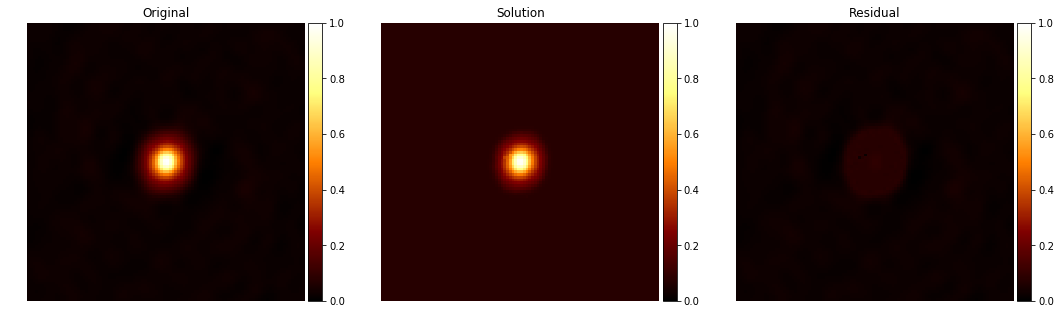

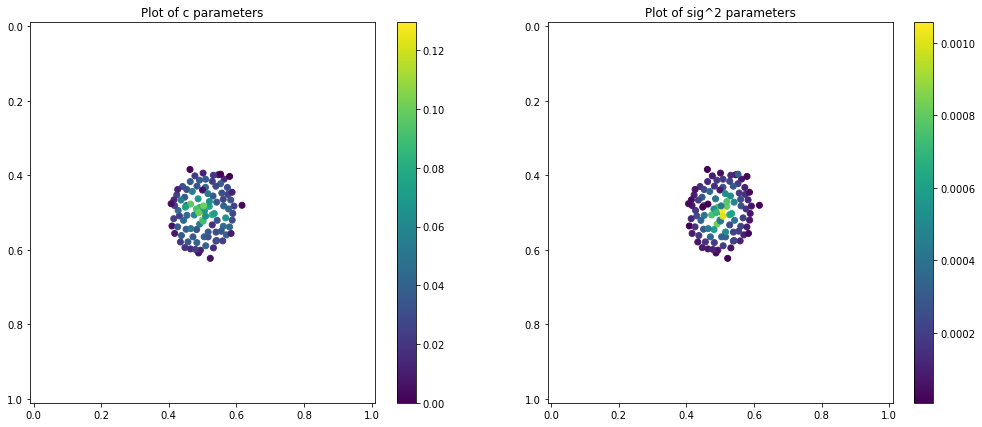

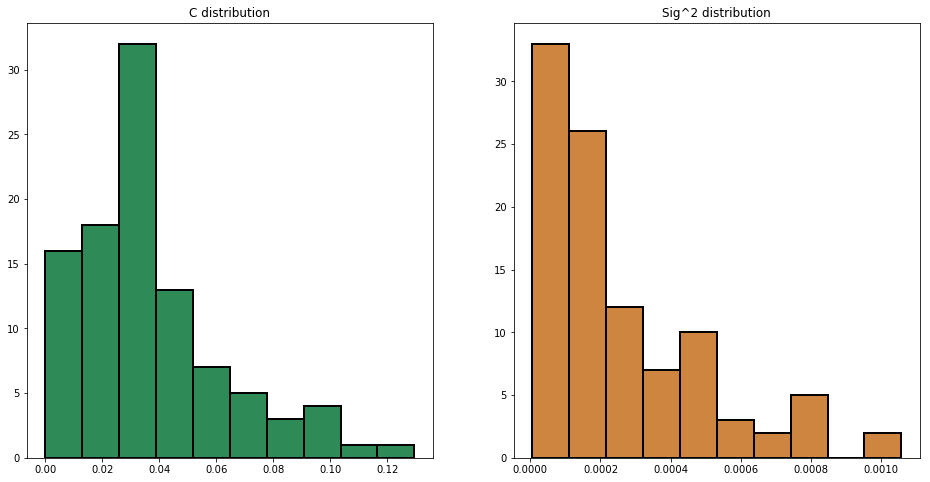

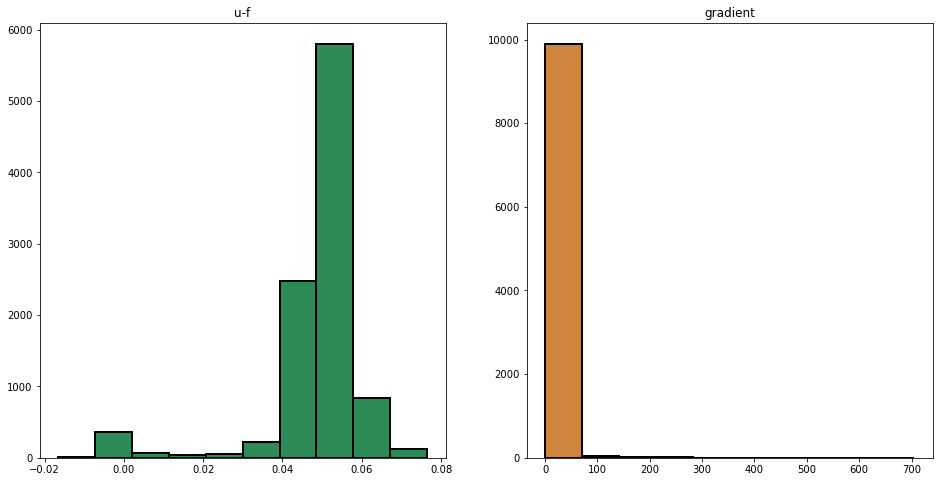

In [41]:
nfev = 100*(len(elm05.get_params())+1)
elm_solver(elm05, method='standard', max_nfev=nfev)

In [42]:
elm05.prune()
xc, yc, c, sig = elm05.get_params_mapped()
w = elm05.get_w()
mu = np.vstack([xc, yc]).T

In [43]:
components_dict05, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 49 and 86 with 2.803053068836333e-07 KL dist and 6.2760846934501076e-15 ISD dist
Merged components 6 and 44 with 5.50988545166108e-07 KL dist and 2.1429400830896197e-10 ISD dist
Merged components 8 and 80 with 6.416906366159671e-07 KL dist and 1.9751347470332955e-10 ISD dist
Merged components 7 and 65 with 8.517700516996068e-07 KL dist and 7.089505886896062e-10 ISD dist
Merged components 53 and 85 with 9.960299834624972e-07 KL dist and 4.030618605988317e-10 ISD dist
Merged components 11 and 45 with 1.2297732606472294e-06 KL dist and 1.1092653485916005e-09 ISD dist
Merged components 12 and 22 with 2.042738661395276e-06 KL dist and 1.971717449550182e-09 ISD dist
Merged components 21 and 70 with 2.295588563197849e-06 KL dist and 1.5862760016812483e-09 ISD dist
Merged components 30 and 38 with 2.8272322632883025e-06 KL dist and 3.144953000476384e-09 ISD dist
Merged components 6 and 20 with 3.1484409052806125e-06 KL dist and 5.554410654499714e-09 ISD dist
Merged components

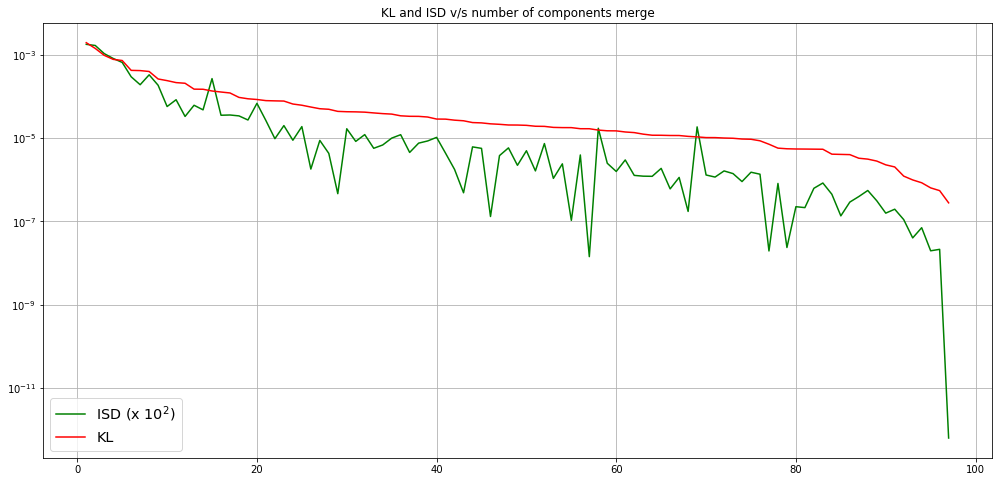

In [44]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [45]:
default_ncomp = ncomp_finder(kl_hist)
interact(components_plot, elm=fixed(elm05), data=fixed(data), components_dict=fixed(components_dict05),\
         n_comp=IntSlider(min=1,max=20,value=default_ncomp), dims=fixed(data.shape), resolution=fixed(1),\
         n_levels=fixed(5))

<function graph.components_plot>

***
***
# `PerA_Extn2MASS_F_Gal`

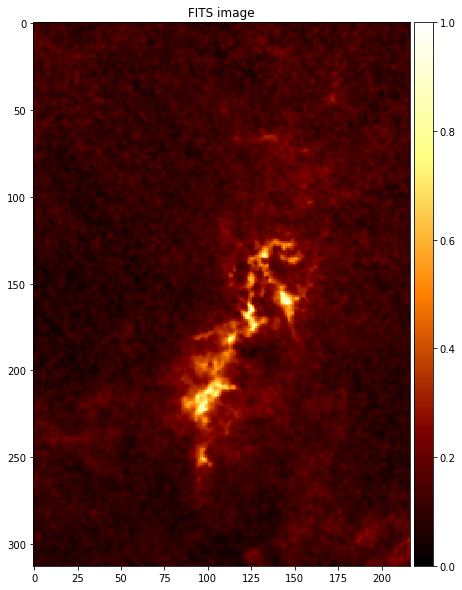

In [46]:
fits_path = '../data/images/PerA_Extn2MASS_F_Gal.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [47]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

In [48]:
base_level = 0.18

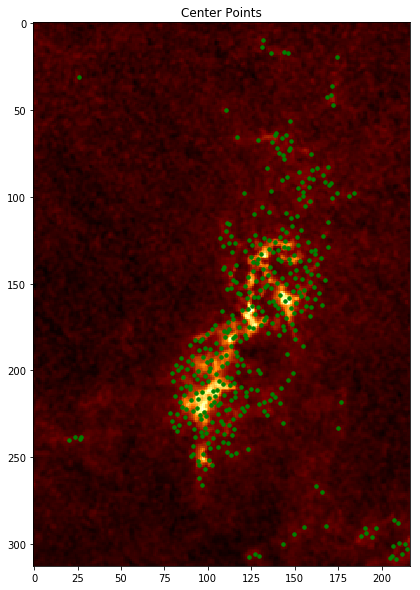

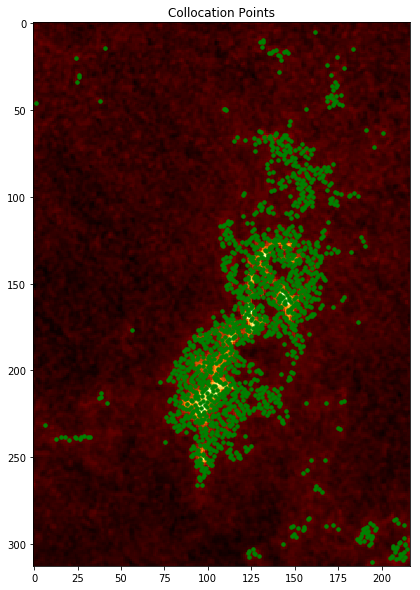

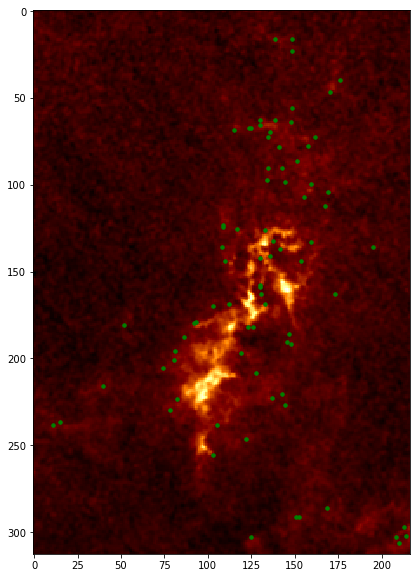

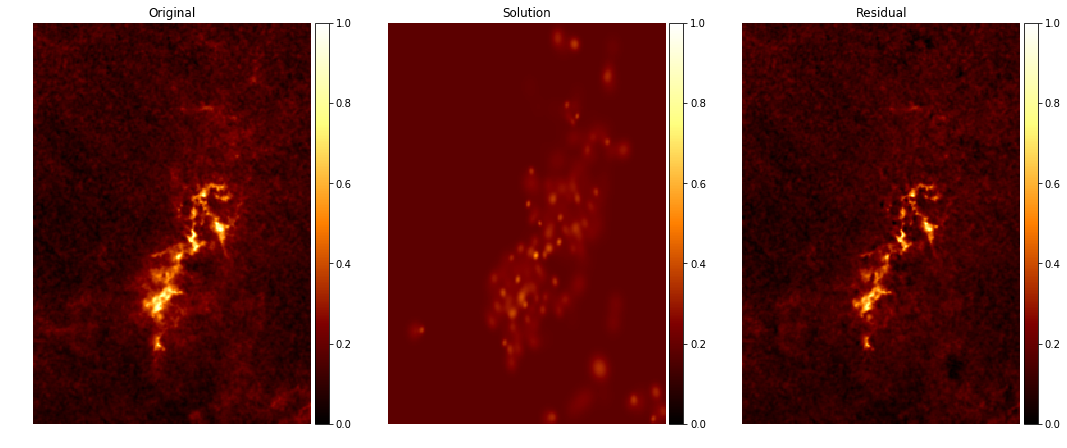

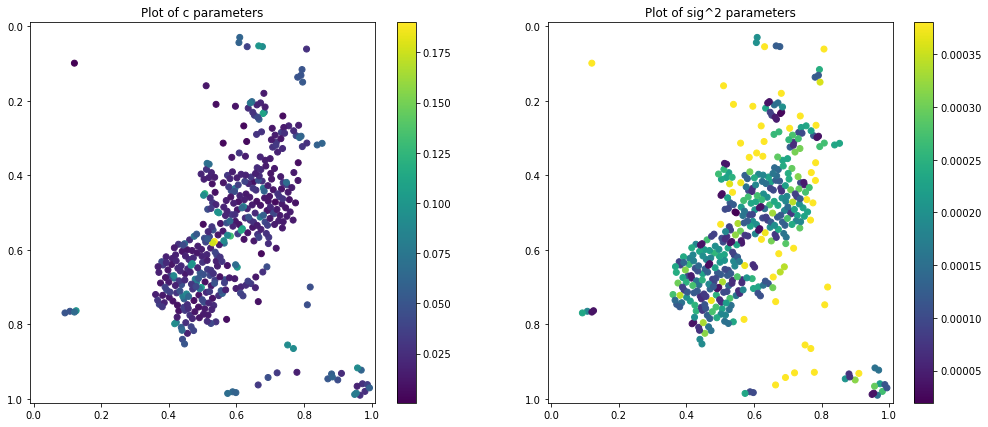

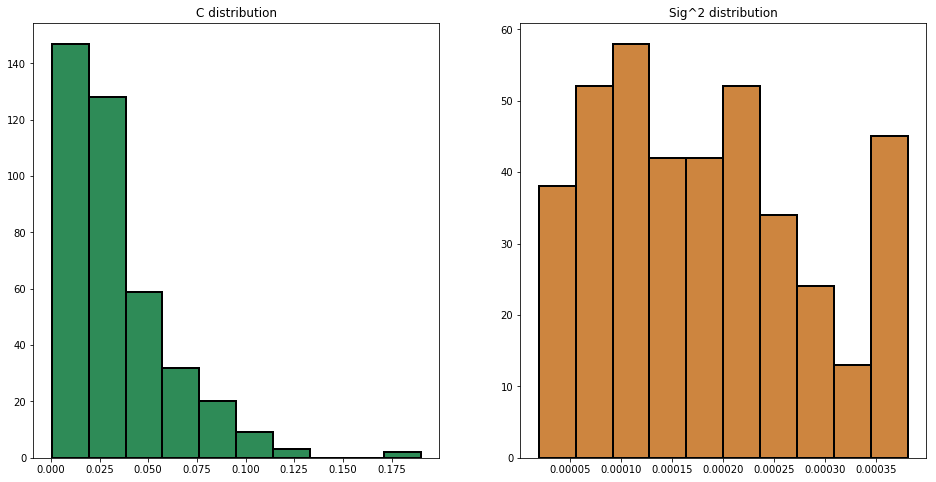

In [49]:
Nc = 400
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm06 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1.,
                base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 160100.
nfev: 160108

Residual stats:
Residual RMS: 0.04068248616937526
Residual Variance: 0.0015677379012351933
Flux Lost: 0.06226700971437859
Flux Addition: 0.027465677895061855
psi1(u-f): 1.2151103776312624
Exceeded Pixels: 3427
Sharpness: 199.67288432839837
psi2(grad u): 195.28106124269647
Total elapsed time: 890.4972429275513 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.139874917387581
Mean min distance between collocation and center points: 0.009009248442053894

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06804338369816762
Max min distance in the (standarized) parameters space: 0.43357551375822034


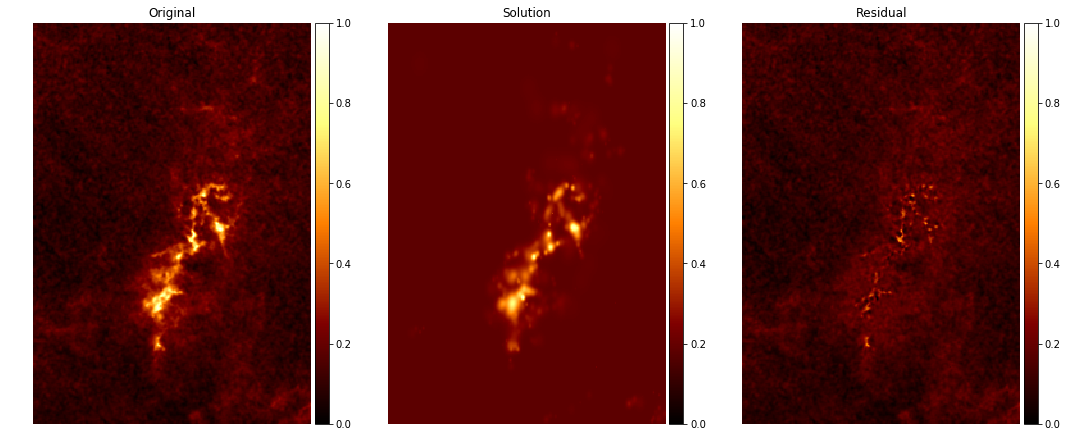

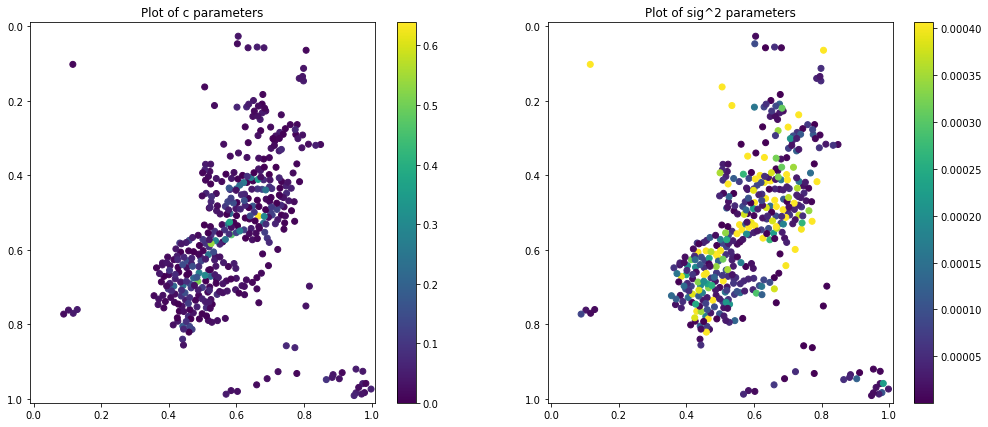

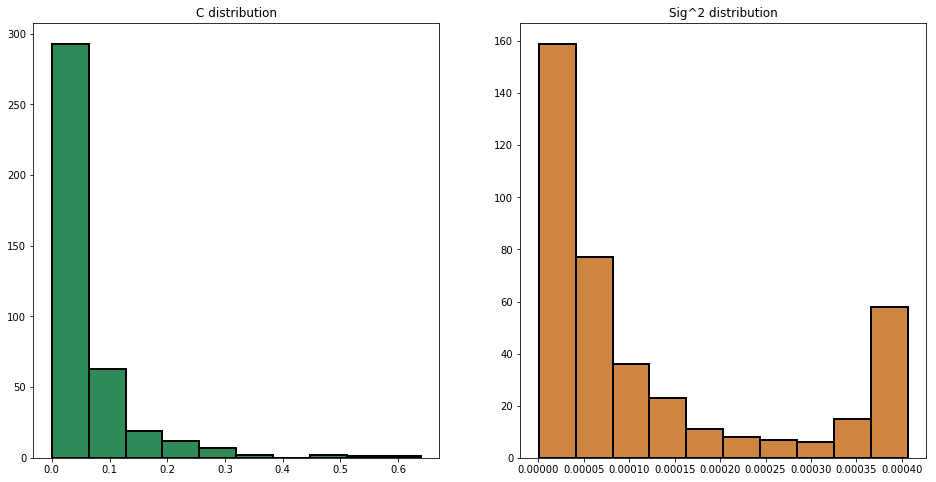

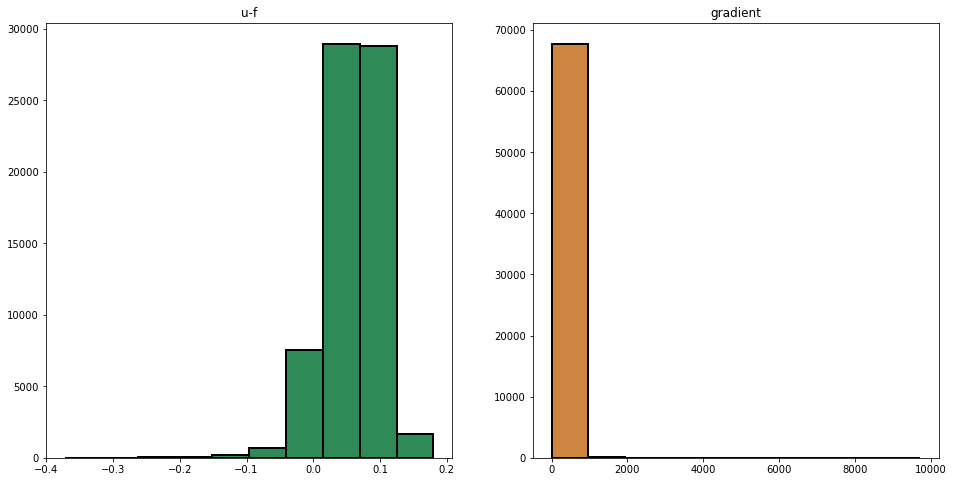

In [50]:
nfev = 100*(len(elm06.get_params())+1)
elm_solver(elm06, method='standard', max_nfev=nfev)